In [1]:
#load packages
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import optuna
from imblearn.pipeline import Pipeline as IMBPipeline
import category_encoders as ce

#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn import svm
from sklearn.naive_bayes import CategoricalNB, GaussianNB, BernoulliNB, MultinomialNB
import xgboost as xgb

#evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

#preprocessing
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
import category_encoders as ce

random_state = 42

c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [66]:
#import data for cybercrime victimisation and age + gender etc
background = pd.read_spss('avars_201802_EN_1.0p.sav')
crime = pd.read_excel('liss_filtered.xlsx')
rac = pd.read_spss('cs17j_EN_1.0p.sav')

# Data preprocessing and merging datasets

In [67]:
#select interesting columns for the background data
#could not select income as most people did not discloser their income.
background = background[['nomem_encr', 'geslacht', 'leeftijd', 'lftdcat', 'aantalki', 'oplcat']]
background.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11483 entries, 0 to 11482
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   nomem_encr  11483 non-null  float64 
 1   geslacht    11483 non-null  category
 2   leeftijd    11483 non-null  float64 
 3   lftdcat     11483 non-null  category
 4   aantalki    11483 non-null  category
 5   oplcat      10893 non-null  category
dtypes: category(4), float64(2)
memory usage: 225.4 KB


In [68]:
#select important columns the crime dataset
crime = crime.drop(['ac18f093', "ac18f098", 'ac18f273', 'ac18f274', 'ac18f276', 'ac18f277', 'ac18f001', 'ac18f002', 'ac18f003', 'ac18f004', 'ac18f005', 'ac18f006', 'ac18f078', 'ac18f079'], axis=1, inplace=False)
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5794 entries, 0 to 5793
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   nomem_encr  5794 non-null   int64         
 1   ac18f092    5794 non-null   int64         
 2   ac18f007    5794 non-null   int64         
 3   ac18f036    5500 non-null   float64       
 4   ac18f126    5499 non-null   float64       
 5   ac18f044    5499 non-null   float64       
 6   ac18f045    5499 non-null   float64       
 7   ac18f220    5499 non-null   float64       
 8   ac18f046    4498 non-null   float64       
 9   ac18f047    5497 non-null   float64       
 10  ac18f048    4498 non-null   float64       
 11  ac18f049    5497 non-null   float64       
 12  ac18f050    5497 non-null   float64       
 13  ac18f051    5497 non-null   float64       
 14  ac18f052    5497 non-null   float64       
 15  ac18f053    5497 non-null   float64       
 16  ac18f054    5497 non-nul

In [69]:
#see how many respondents of these datasets correspond
common_ids = pd.merge(background, crime, on='nomem_encr')
print("Number of common IDs:", len(common_ids))
print("lenght of crime dataset:", len(crime))

Number of common IDs: 5792
lenght of crime dataset: 5794


## Addition of routine activities dataset

In [70]:
#exploratory data analysis rac and select proper columns
rac = rac[['nomem_encr', 'cs17j251', 'cs17j252', 'cs17j253', 'cs17j254', 'cs17j429', 'cs17j430', 'cs17j260', 'cs17j261', 'cs17j262', 'cs17j263', 'cs17j431', 'cs17j432', 'cs17j486', 'cs17j264', 'cs17j435', 'cs17j265', 'cs17j266']]

missing_percentages = rac.isnull().sum(axis=1) / len(rac.columns) * 100

# Filter out rows where the percentage of missing values is higher than 90%
threshold = 50
rac = rac[missing_percentages <= threshold]

rac.head(50)

nomem_encr cs17j251 cs17j252 cs17j253 cs17j254 cs17j429 cs17j430 cs17j260  \
0     800009.0      yes      yes      yes      yes      yes      yes      yes   
1     800015.0      yes      yes      yes      yes       no       no      yes   
2     800042.0      yes      yes      yes      yes      yes       no      yes   
3     800054.0      yes      yes      yes      yes      yes      yes      yes   
4     800057.0      yes      yes      yes      yes      yes      yes      yes   
5     800073.0      yes      yes      yes      yes       no       no      yes   
6     800085.0      yes      yes      yes      yes      yes       no      yes   
7     800100.0      yes       no       no      yes       no       no      yes   
9     800131.0      yes      yes      yes      yes       no       no      yes   
10    800151.0      yes      yes       no       no       no       no       no   
11    800161.0      yes      yes      yes      yes      yes      yes      yes   
12    800170.0      yes      yes      yes      yes       no       no      yes   
13    800186.0      yes      yes       no       no       no       no      yes   
14    800201.0      yes      yes      yes      yes      yes      yes      yes   
15    800204.0      yes      yes      yes      yes       no       no      yes   
16    800216.0      yes      yes      yes      yes       no       no      yes   
17    800228.0      yes      yes      yes      yes       no       no      yes   
18    800244.0      yes      yes      yes      yes       no       no      yes   
19    800253.0      yes      yes      yes      yes      yes      yes      yes   
20    800274.0      yes      yes      yes      yes      yes       no      yes   
21    800289.0      yes      yes      yes      yes       no       no      yes   
22    800360.0      yes      yes      yes      yes       no       no      yes   
23    800372.0      yes      yes      yes      yes      yes      yes      yes   
24    800440.0      yes      yes      yes      yes      yes      yes      yes   
25    800445.0      yes      yes      yes      yes       no       no      yes   
26    800463.0      yes      yes      yes      yes      yes      yes      yes   
27    800473.0      yes      yes      yes      yes      yes      yes      yes   
28    800497.0      yes      yes       no       no       no       no      yes   
29    800500.0      yes      yes      yes      yes       no       no      yes   
30    800512.0      yes      yes      yes      yes      yes      yes      yes   
32    800543.0      yes      yes      yes      yes       no       no      yes   
33    800552.0      yes      yes      yes      yes       no       no      yes   
34    800561.0      yes      yes      yes      yes       no      yes      yes   
35    800570.0      yes      yes      yes      yes       no       no      yes   
36    800573.0      yes      yes      yes      yes      yes      yes      yes   
37    800585.0      yes      yes      yes      yes      yes      yes      yes   
38    800631.0      yes      yes      yes      yes      yes       no      yes   
39    800659.0      yes      yes      yes      yes       no       no      yes   
40    800665.0      yes      yes      yes      yes      yes      yes      yes   
41    800671.0      yes      yes      yes      yes       no       no      yes   
42    800674.0      yes      yes      yes      yes      yes       no      yes   
43    800677.0      yes      yes      yes      yes      yes      yes      yes   
44    800683.0      yes      yes      yes      yes      yes      yes      yes   
45    800695.0      yes      yes       no       no       no       no       no   
46    800701.0      yes      yes      yes      yes      yes      yes      yes   
47    800704.0      yes      yes      yes      yes      yes       no      yes   
48    800714.0      yes      yes      yes      yes      yes       no      yes   
49    800750.0      yes      yes      yes      yes       no       no      yes   
50    800762.0      yes      yes   

In [71]:
#see how many columns are the same and combine all
finalcombined = pd.merge(common_ids, rac, on='nomem_encr')
print("Number of common IDs:", len(finalcombined))
print("lenght of crime dataset:", len(common_ids))

Number of common IDs: 5436
lenght of crime dataset: 5792


In [72]:
finalcombined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5436 entries, 0 to 5435
Data columns (total 70 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   nomem_encr  5436 non-null   float64       
 1   geslacht    5436 non-null   category      
 2   leeftijd    5436 non-null   float64       
 3   lftdcat     5436 non-null   category      
 4   aantalki    5436 non-null   category      
 5   oplcat      5426 non-null   category      
 6   ac18f092    5436 non-null   int64         
 7   ac18f007    5436 non-null   int64         
 8   ac18f036    5232 non-null   float64       
 9   ac18f126    5231 non-null   float64       
 10  ac18f044    5231 non-null   float64       
 11  ac18f045    5231 non-null   float64       
 12  ac18f220    5231 non-null   float64       
 13  ac18f046    4275 non-null   float64       
 14  ac18f047    5229 non-null   float64       
 15  ac18f048    4275 non-null   float64       
 16  ac18f049    5229 non-nul

### Cleaning data and removing incomplete cases

In [73]:
#drop incomplete cases from the set
cleaned_df = finalcombined.dropna(subset=['ac18f275']).drop('ac18f275', axis= 1)

#drop cases where there is missing information in the target labels
cleaned_df = cleaned_df.dropna(subset=['ac18f221'])

cleaned_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 5219 entries, 0 to 5435
Data columns (total 69 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   nomem_encr  5219 non-null   float64 
 1   geslacht    5219 non-null   category
 2   leeftijd    5219 non-null   float64 
 3   lftdcat     5219 non-null   category
 4   aantalki    5219 non-null   category
 5   oplcat      5210 non-null   category
 6   ac18f092    5219 non-null   int64   
 7   ac18f007    5219 non-null   int64   
 8   ac18f036    5219 non-null   float64 
 9   ac18f126    5219 non-null   float64 
 10  ac18f044    5219 non-null   float64 
 11  ac18f045    5219 non-null   float64 
 12  ac18f220    5219 non-null   float64 
 13  ac18f046    4268 non-null   float64 
 14  ac18f047    5219 non-null   float64 
 15  ac18f048    4268 non-null   float64 
 16  ac18f049    5219 non-null   float64 
 17  ac18f050    5219 non-null   float64 
 18  ac18f051    5219 non-null   float64 
 19  ac18f052   

In [74]:
#drop rows with more than 50% of missing information 
missing_percentages = cleaned_df.isnull().sum(axis=1) / len(cleaned_df.columns) * 100

# Filter out rows where the percentage of missing values is higher than 90%
threshold = 50
cleaned_df = cleaned_df[missing_percentages <= threshold]
cleaned_df = cleaned_df.drop('nomem_encr', axis= 1)


cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5219 entries, 0 to 5435
Data columns (total 68 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geslacht  5219 non-null   category
 1   leeftijd  5219 non-null   float64 
 2   lftdcat   5219 non-null   category
 3   aantalki  5219 non-null   category
 4   oplcat    5210 non-null   category
 5   ac18f092  5219 non-null   int64   
 6   ac18f007  5219 non-null   int64   
 7   ac18f036  5219 non-null   float64 
 8   ac18f126  5219 non-null   float64 
 9   ac18f044  5219 non-null   float64 
 10  ac18f045  5219 non-null   float64 
 11  ac18f220  5219 non-null   float64 
 12  ac18f046  4268 non-null   float64 
 13  ac18f047  5219 non-null   float64 
 14  ac18f048  4268 non-null   float64 
 15  ac18f049  5219 non-null   float64 
 16  ac18f050  5219 non-null   float64 
 17  ac18f051  5219 non-null   float64 
 18  ac18f052  5219 non-null   float64 
 19  ac18f053  5219 non-null   float64 
 20  ac18f054  521

Percentage of missing data per column:
oplcat       0.172447
ac18f046    18.221882
ac18f048    18.221882
ac18f055     0.632305
ac18f223    18.221882
ac18f066     1.168806
ac18f067     1.168806
ac18f068     1.168806
ac18f069     1.168806
ac18f070     1.168806
ac18f071     1.168806
dtype: float64


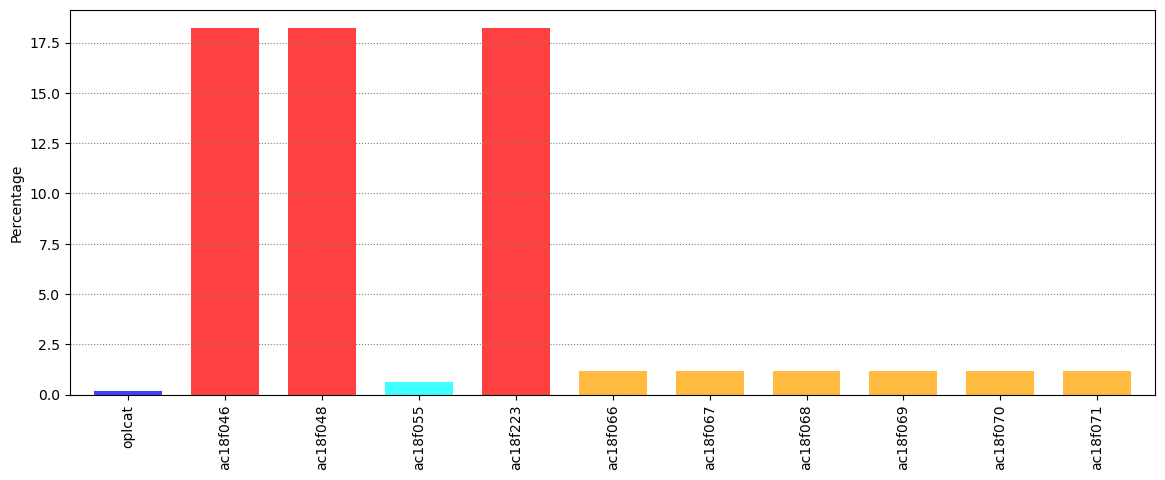

In [93]:
#display missing infomration ratios
missing_ratio = cleaned_df.isna().sum() / len(cleaned_df) * 100

# Filter columns that have any missing values
missing_ratio = missing_ratio[missing_ratio > 0]
print("Percentage of missing data per column:")
print(missing_ratio)

fig, ax = plt.subplots(figsize = (14,5))
missing_ratio.plot(kind='bar', color = ['blue', 'red', 'red', 'cyan', 'red', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange'], alpha = 0.75, width = 0.7)
plt.grid(True, which= 'both', axis='y', linestyle = ':', color='gray')   
plt.ylabel("Percentage") 
plt.show()


In [75]:
#look at unique values in dataset for the detection of outliers
for column in cleaned_df.columns:
    unique_values = cleaned_df[column].unique()
    if len(unique_values) > 10:
        print(f"Unique values in '{column}': {len(unique_values)} unique values")
    else:
        print(f"Unique values in '{column}': {unique_values}")

Unique values in 'geslacht': ['Male', 'Female']
Categories (2, object): ['Female', 'Male']
Unique values in 'leeftijd': 79 unique values
Unique values in 'lftdcat': ['55 - 64 years', '35 - 44 years', '65 years and older', '45 - 54 years', '15 - 24 years', '25 - 34 years']
Categories (7, object): ['14 years and younger', '15 - 24 years', '25 - 34 years', '35 - 44 years', '45 - 54 years', '55 - 64 years', '65 years and older']
Unique values in 'aantalki': ['None', 'Two children', 'Three children', 'One child', 'Four children', 'Five children', 'Six children']
Categories (7, object): ['Five children', 'Four children', 'None', 'One child', 'Six children', 'Three children', 'Two children']
Unique values in 'oplcat': ['hbo (higher vocational education, US: college)', 'wo (university)', 'havo/vwo (higher secondary education/preparat..., 'vmbo (intermediate secondary education, US: j..., 'mbo (intermediate vocational education, US: j..., 'primary school', NaN]
Categories (6, object): ['havo/vw

In [12]:
cleaned_df['oplcat'].value_counts()

oplcat
hbo (higher vocational education, US: college)                                                    1373
mbo (intermediate vocational education, US: junior college)                                       1228
vmbo (intermediate secondary education, US: junior high school)                                   1010
wo (university)                                                                                    660
havo/vwo (higher secondary education/preparatory university education, US: senior high school)     605
primary school                                                                                     334
Name: count, dtype: int64

In [13]:
#impute missing values for education variable
cleaned_df['oplcat'] = cleaned_df['oplcat'].fillna('hbo (higher vocational education, US: college)')

In [14]:
#put data in the correct format

#for gender column
cleaned_df['geslacht'] = cleaned_df['geslacht'].map({'Female': 1, 'Male': 0})

#for age category column
cleaned_df['lftdcat'] = cleaned_df['lftdcat'].map({'15 - 24 years': 1, '25 - 34 years': 2, '35 - 44 years': 3, '45 - 54 years': 4, '55 - 64 years': 5, '65 years and older': 6, '14 years and younger': 0})

#amount of children
cleaned_df['aantalki'] = cleaned_df['aantalki'].map({'None':0, 'Two children':2, 'Three children':3, 'One child':1, 'Four children':4, 'Five children':5, 'Six children':6})

#for eduction
cleaned_df['oplcat'] = cleaned_df['oplcat'].map({'primary school':1, 'vmbo (intermediate secondary education, US: junior high school)':2, 'havo/vwo (higher secondary education/preparatory university education, US: senior high school)':3, 'mbo (intermediate vocational education, US: junior college)':4, 'hbo (higher vocational education, US: college)':5, 'wo (university)':6})

#for yes/no columns
columns = ['cs17j251', 'cs17j252', 'cs17j253', 'cs17j254', 'cs17j429', 'cs17j430', 'cs17j260', 'cs17j261', 'cs17j262', 'cs17j263', 'cs17j431', 'cs17j432', 'cs17j486', 'cs17j264', 'cs17j435', 'cs17j265', 'cs17j266']

for column in columns :
    cleaned_df[column] = cleaned_df[column].map({'yes': 1, 'no': 0})

category = ['cs17j251', 'cs17j252', 'cs17j253', 'cs17j429', 'cs17j430', 'cs17j261', 'cs17j262', 'cs17j263', 'cs17j431', 'cs17j432', 'cs17j486', 'cs17j264', 'cs17j435', 'cs17j265', 'cs17j266', 'geslacht', 'lftdcat', 'aantalki', 'oplcat']

for column in category :
    cleaned_df[column] = cleaned_df[column].astype('int')

#change certain values to 0 category
columns_6 = ["ac18f046", "ac18f047", "ac18f048", "ac18f049", "ac18f050", "ac18f051", "ac18f052", "ac18f053", "ac18f054", "ac18f055"]
for column in columns_6:
    cleaned_df[column] = cleaned_df[column].apply(lambda x: 0 if x == 6 else x)

#98/99 to 0
columns_99 = ["ac18f126", "ac18f044", "ac18f045", "ac18f220"]
for column in columns_99:
    cleaned_df[column] = cleaned_df[column].apply(lambda x: 0 if x == 99 or x == 98 else x)

#fill in missing information of certain columns
cleaned_df = cleaned_df.fillna({"ac18f046": 0, "ac18f048": 0, "ac18f055": 0, 'ac18f066': 4, 'ac18f067': 4,'ac18f068': 4,'ac18f069': 4, 'ac18f070': 4, 'ac18f071': 4, 'ac18f223':2})

cleaned_df.head()

geslacht  leeftijd  lftdcat  aantalki  oplcat  ac18f092  ac18f007  \
0         0      62.0        5         0       5         1         3   
1         0      55.0        5         2       6         1         1   
2         1      42.0        3         2       3         2         1   
3         1      71.0        6         0       2         1         4   
4         0      43.0        3         3       6         3         1   

   ac18f036  ac18f126  ac18f044  ...  cs17j261  cs17j262  cs17j263  cs17j431  \
0      10.0       3.0       1.0  ...         0         1         1         1   
1       6.0       1.0       1.0  ...         0         1         0         1   
2       8.0       3.0       1.0  ...         0         1         0         1   
3       1.0       4.0       1.0  ...         1         1         1         1   
4       9.0       1.0       1.0  ...         1         1         1         1   

   cs17j432  cs17j486  cs17j264  cs17j435  cs17j265  cs17j266  
0         1         1         1         0         1         1  
1         1         0         0         0         0         0  
2         0         1         1         0         0         1  
3         0         1         0         0         0         0  
4         1         1         1         0         1         1  

[5 rows x 68 columns]

In [15]:
#final check on data
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5219 entries, 0 to 5435
Data columns (total 68 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geslacht  5219 non-null   int32   
 1   leeftijd  5219 non-null   float64 
 2   lftdcat   5219 non-null   int32   
 3   aantalki  5219 non-null   int32   
 4   oplcat    5219 non-null   int32   
 5   ac18f092  5219 non-null   int64   
 6   ac18f007  5219 non-null   int64   
 7   ac18f036  5219 non-null   float64 
 8   ac18f126  5219 non-null   float64 
 9   ac18f044  5219 non-null   float64 
 10  ac18f045  5219 non-null   float64 
 11  ac18f220  5219 non-null   float64 
 12  ac18f046  5219 non-null   float64 
 13  ac18f047  5219 non-null   float64 
 14  ac18f048  5219 non-null   float64 
 15  ac18f049  5219 non-null   float64 
 16  ac18f050  5219 non-null   float64 
 17  ac18f051  5219 non-null   float64 
 18  ac18f052  5219 non-null   float64 
 19  ac18f053  5219 non-null   float64 
 20  ac18f054  521

In [16]:
#remove outliers from the column where amount of computers owned is specified

cleaned_df = cleaned_df[cleaned_df['ac18f036'] <= 20]

#cleaned_df = cleaned_df[cleaned_df['ac18f092'] != 9]
cleaned_df['ac18f092'].value_counts()

ac18f092
1    3215
2    1254
5     413
3     279
6      34
7      14
4       5
9       2
Name: count, dtype: int64

# Save clean dataset

In [17]:
cleaned_df.to_csv('final_data.csv', index=False)

### load cleaned dataset

In [18]:
data = pd.read_csv('final_data.csv')

### Split labels and parameters

In [19]:
parameters = data.drop(["ac18f279", "ac18f280", "ac18f281", "ac18f282", "ac18f221", "ac18f222", "ac18f223", "ac18f224", "ac18f225" ,"ac18f226", "ac18f285"], axis= 1)
labels = data[["ac18f279", "ac18f280", "ac18f281", "ac18f282", "ac18f221", "ac18f222", "ac18f223", "ac18f224", "ac18f225" ,"ac18f226", "ac18f285"]]

### Creation of preprocessor for pipeline

In [88]:
#Transform ceratain labels using OneHotEncoder

# Define which columns to OneHotEncode and which to passthrough
onehot_cols = ['ac18f092', 'ac18f007', 'ac18f045', 'ac18f066', 'ac18f067', 'ac18f069', 'ac18f070', 'ac18f071', 'ac18f080', 'ac18f081', 'ac18f082', 'ac18f083', 'ac18f084', 'ac18f085', 'ac18f087', 'ac18f088', 'ac18f089', 'ac18f090', 'ac18f091']

# Create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_cols)
    ],
    remainder='passthrough'
)

In [20]:
#change labels to correct format
columns_binary = ['ac18f221', 'ac18f222',	'ac18f223',	'ac18f224',	'ac18f225',	'ac18f226',	'ac18f285']
for column in columns_binary:
    # Replace values higher than 1 with 0 in the current column
    labels.loc[:, column] = labels[column].apply(lambda x: 0 if x > 1 else x)

#malware labels
columns_malware = ['ac18f279',  'ac18f280',  'ac18f281',  'ac18f282']
for column in columns_malware:
    # Replace values higher than 1 with 0 in the current column
    labels.loc[:, column] = labels[column].apply(lambda x: 0 if x == 1 or x == 6 else x)

labels['malware'] = labels[columns_malware].apply(lambda x: all(i > 0 for i in x), axis=1).astype(int)

print(labels.head())
print(labels['malware'].value_counts())

   ac18f279  ac18f280  ac18f281  ac18f282  ac18f221  ac18f222  ac18f223  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       3.0       2.0       0.0       0.0       0.0       0.0       0.0   
3       4.0       2.0       0.0       0.0       0.0       0.0       0.0   
4       3.0       5.0       0.0       0.0       0.0       0.0       0.0   

   ac18f224  ac18f225  ac18f226  ac18f285  malware  
0       0.0       0.0       0.0       0.0        0  
1       0.0       0.0       0.0       0.0        0  
2       0.0       0.0       0.0       0.0        0  
3       0.0       0.0       0.0       0.0        0  
4       0.0       0.0       0.0       0.0        0  
malware
0    4928
1     288
Name: count, dtype: int64


C:\Users\samsm\AppData\Local\Temp\ipykernel_20992\3650888978.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['malware'] = labels[columns_malware].apply(lambda x: all(i > 0 for i in x), axis=1).astype(int)


# EDA graphs of the data

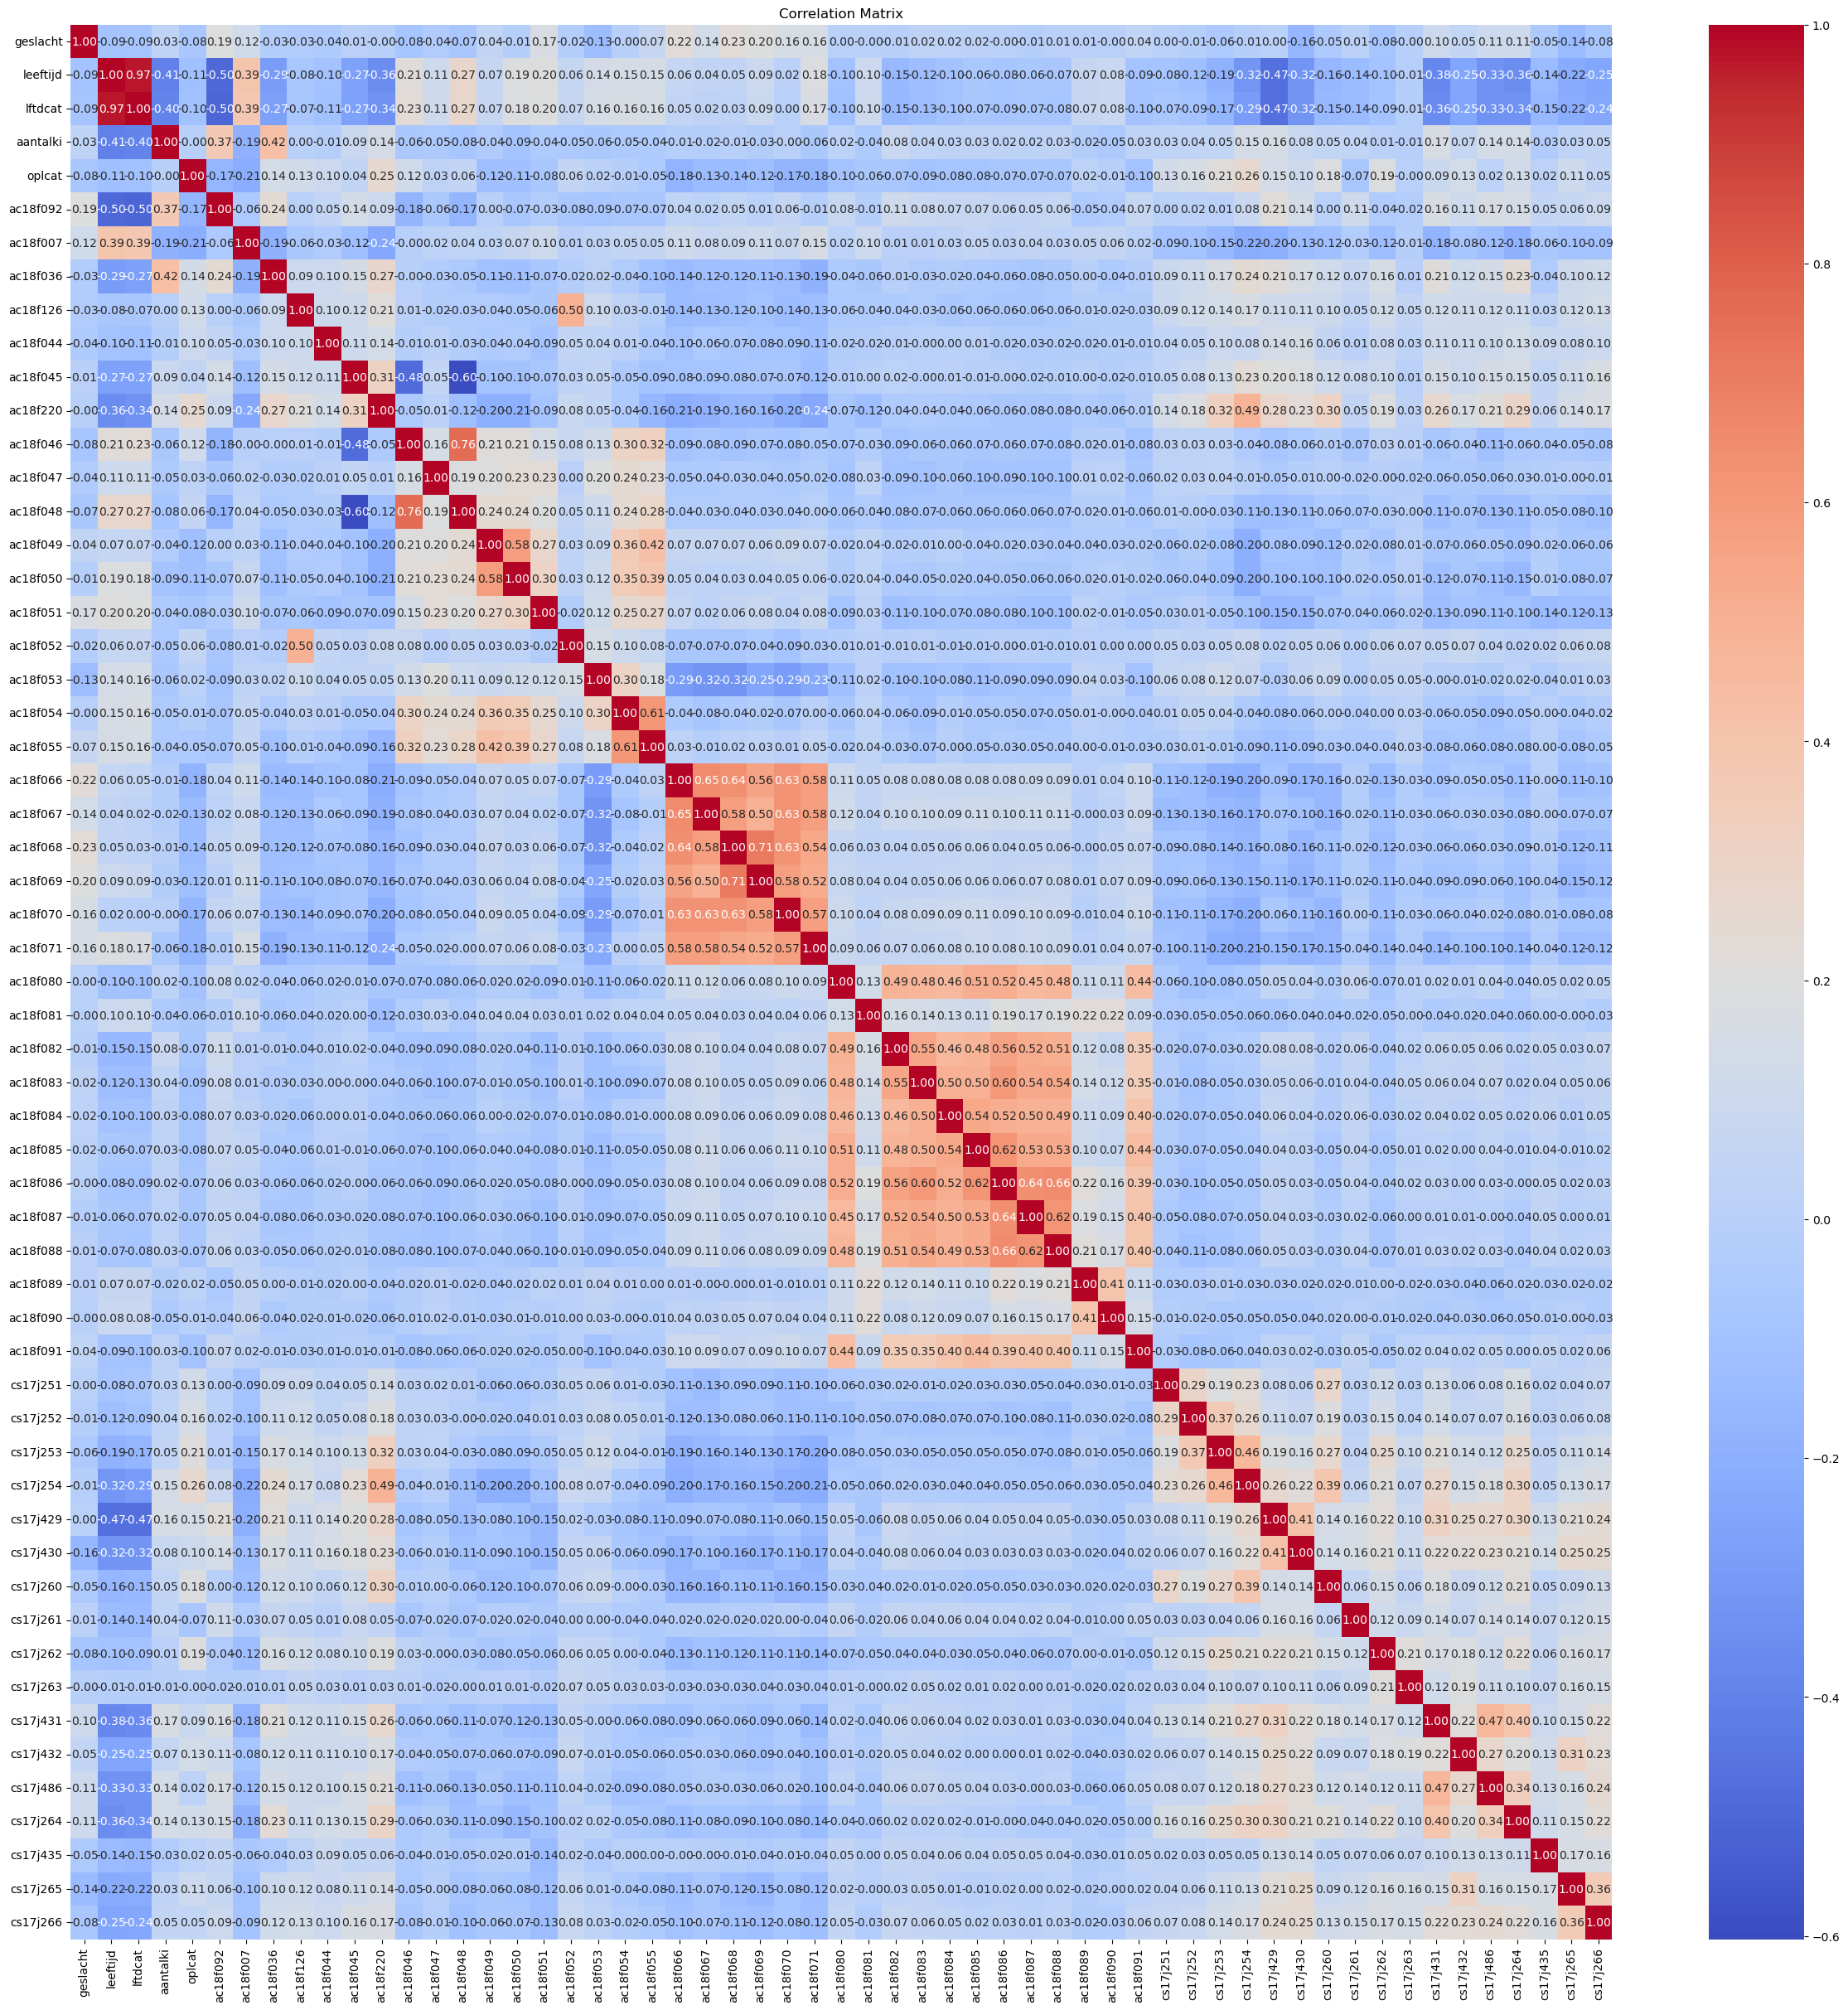

In [90]:
#correlation matrix of the parameters
correlation_matrix = parameters.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

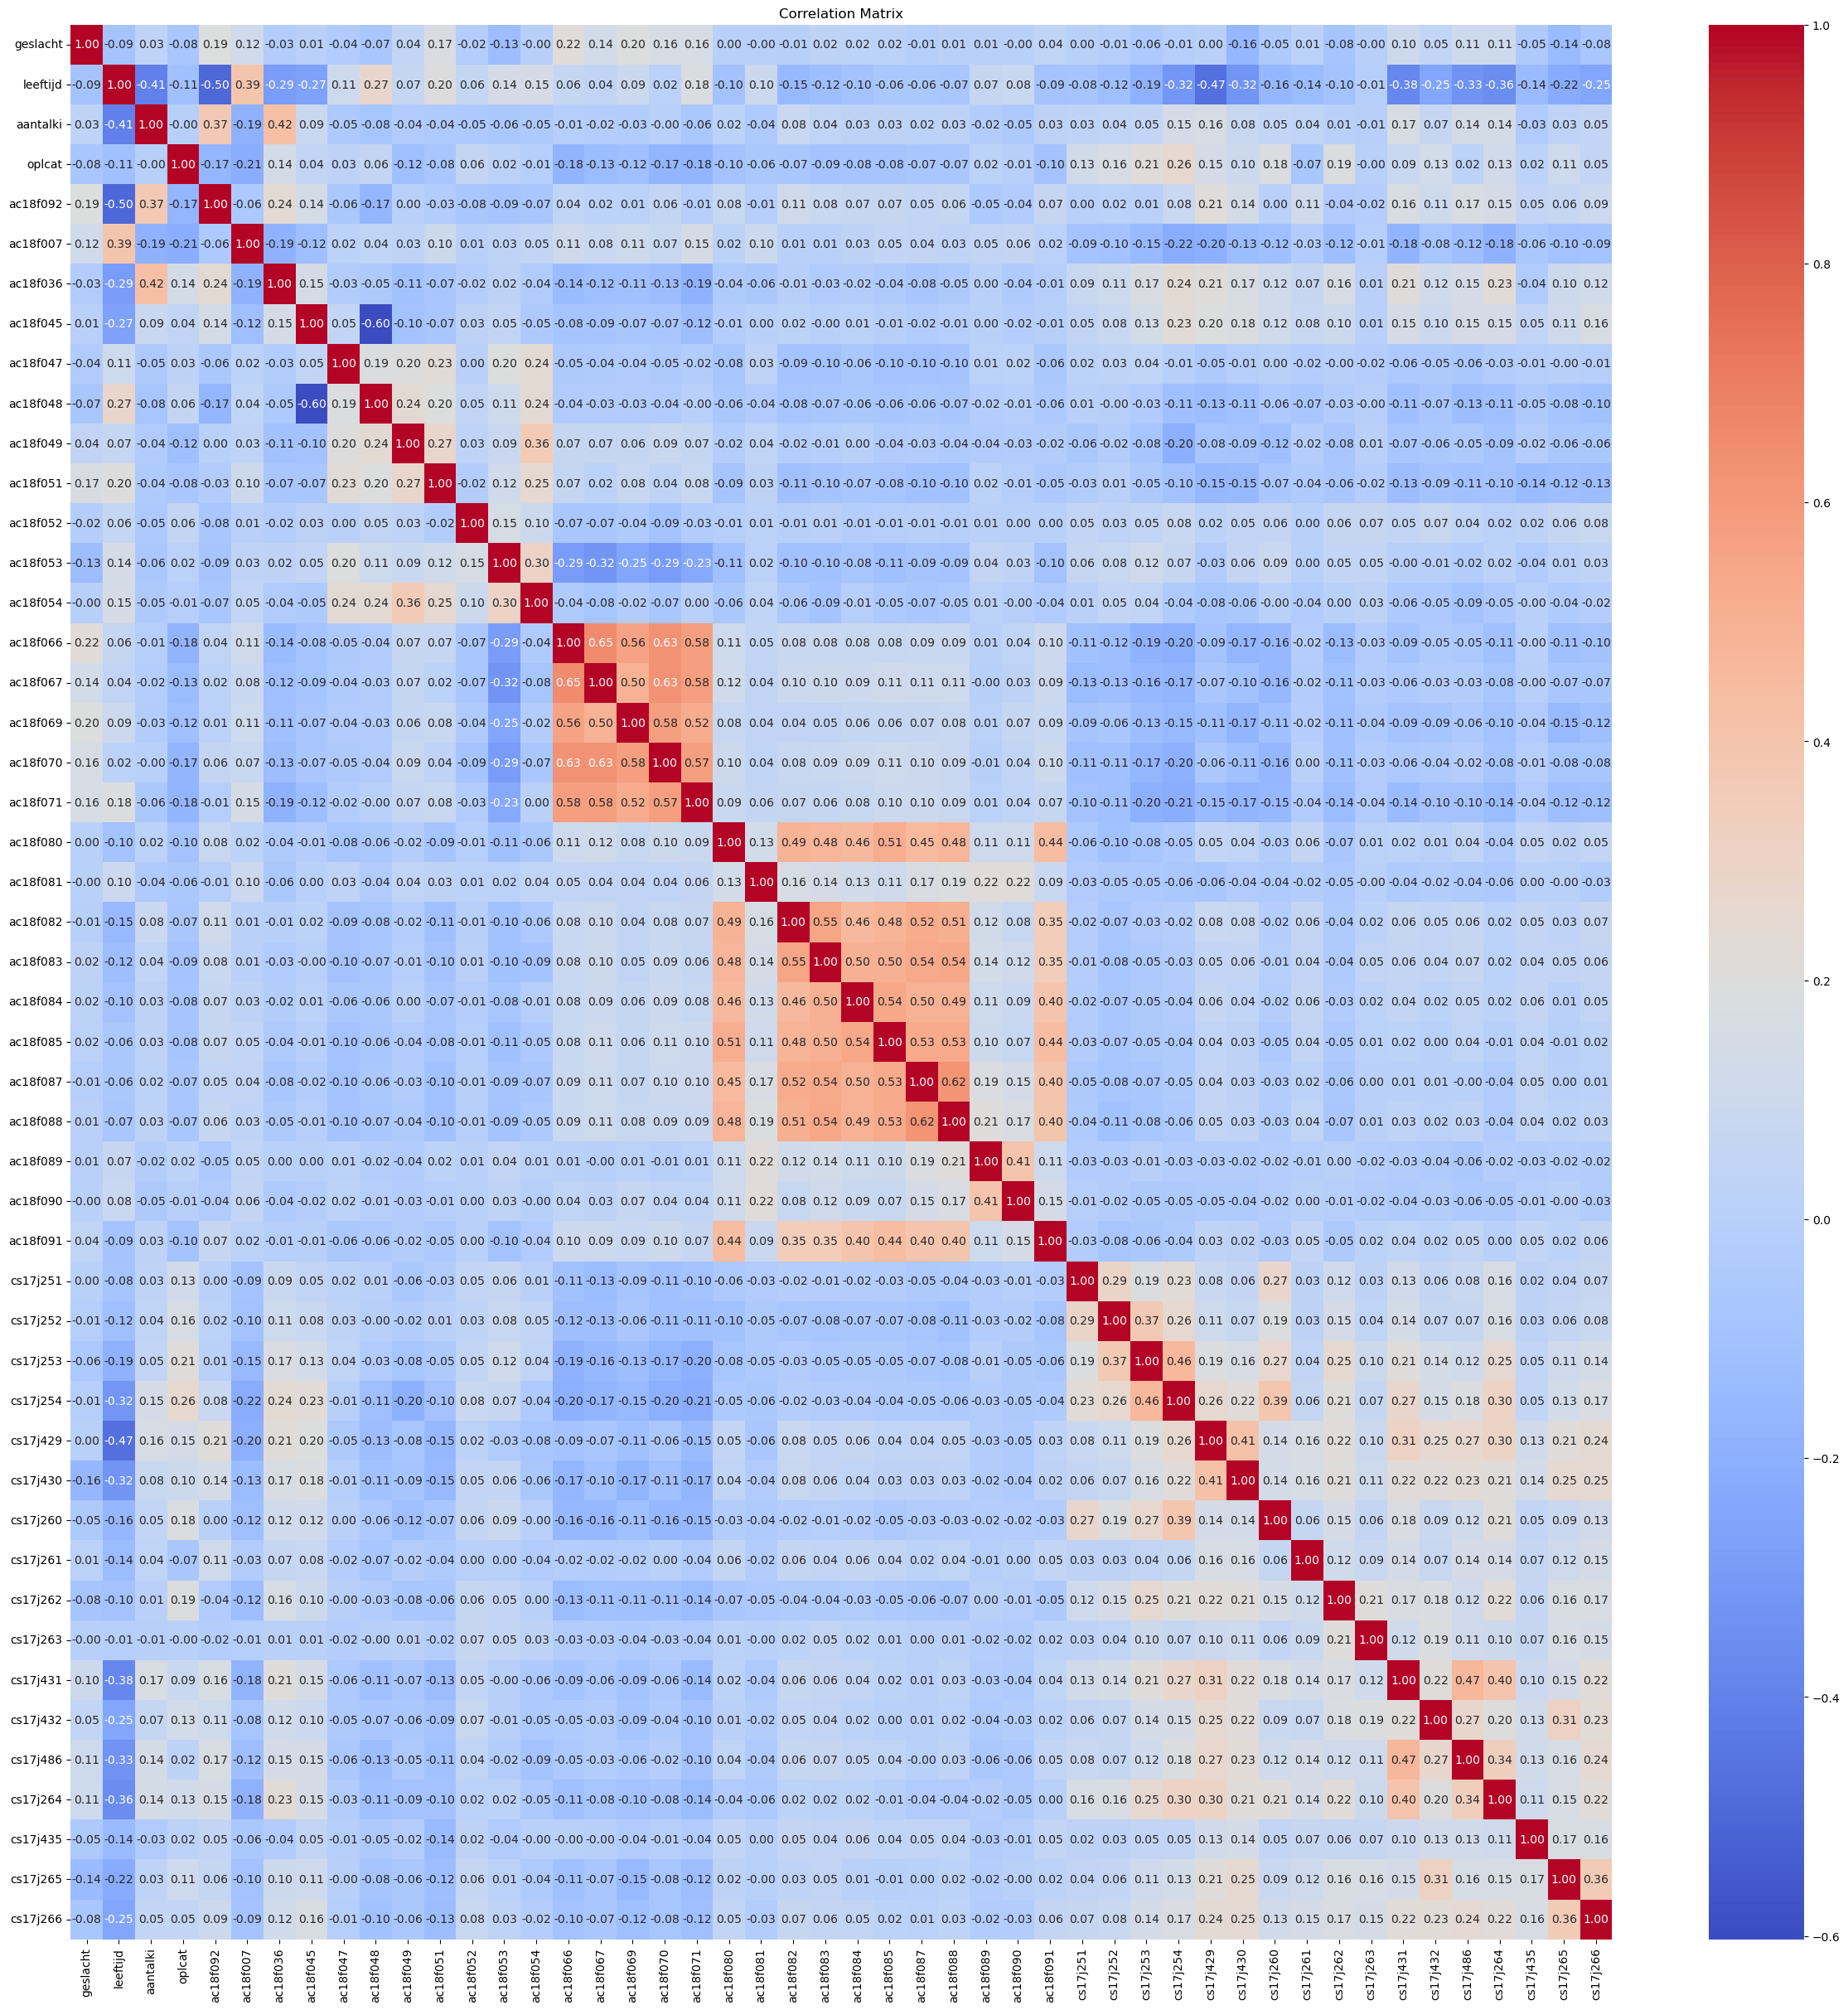

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 48 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   geslacht  5216 non-null   int64  
 1   leeftijd  5216 non-null   float64
 2   aantalki  5216 non-null   int64  
 3   oplcat    5216 non-null   int64  
 4   ac18f092  5216 non-null   int64  
 5   ac18f007  5216 non-null   int64  
 6   ac18f036  5216 non-null   float64
 7   ac18f045  5216 non-null   float64
 8   ac18f047  5216 non-null   float64
 9   ac18f048  5216 non-null   float64
 10  ac18f049  5216 non-null   float64
 11  ac18f051  5216 non-null   float64
 12  ac18f052  5216 non-null   float64
 13  ac18f053  5216 non-null   float64
 14  ac18f054  5216 non-null   float64
 15  ac18f066  5216 non-null   float64
 16  ac18f067  5216 non-null   float64
 17  ac18f069  5216 non-null   float64
 18  ac18f070  5216 non-null   float64
 19  ac18f071  5216 non-null   float64
 20  ac18f080  5216 non-null   floa

In [91]:
#remove further columns which are highly corellated and check again. 
parameters = parameters.drop(['ac18f126', 'lftdcat', 'ac18f046', 'ac18f050', 'ac18f055', 'ac18f068', 'ac18f220','ac18f086', 'ac18f044'], axis= 1)

correlation_matrix = parameters.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

print(parameters.info())

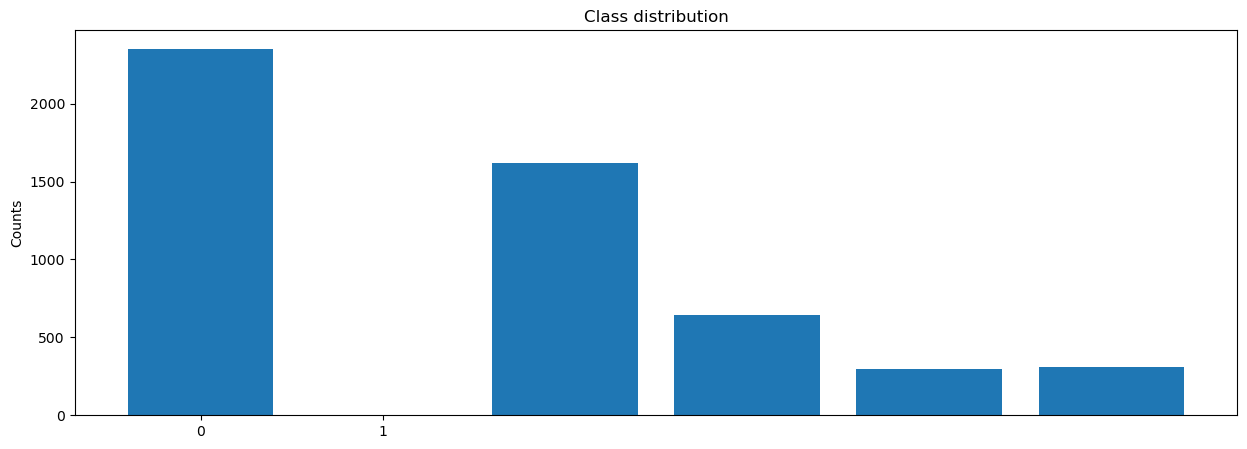

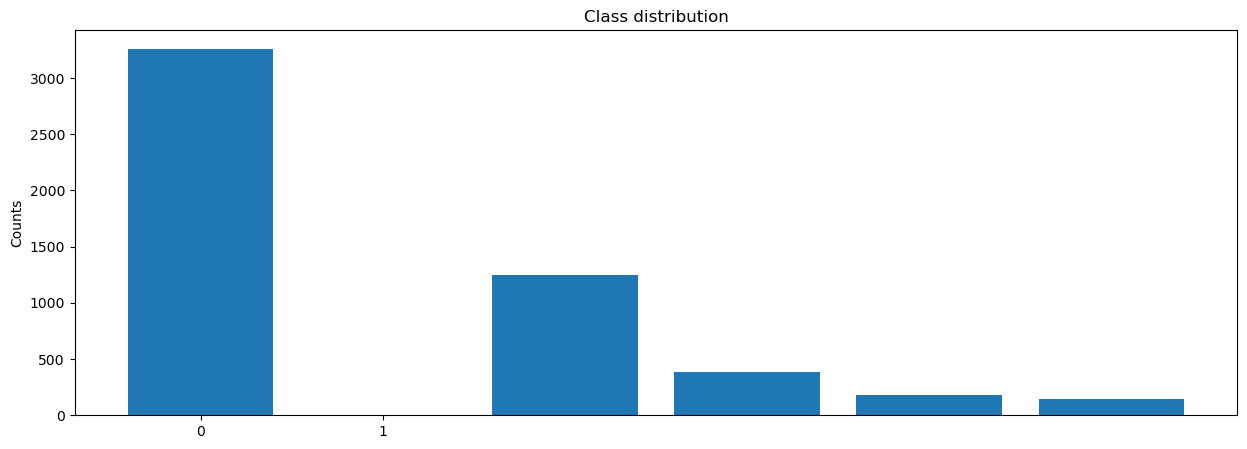

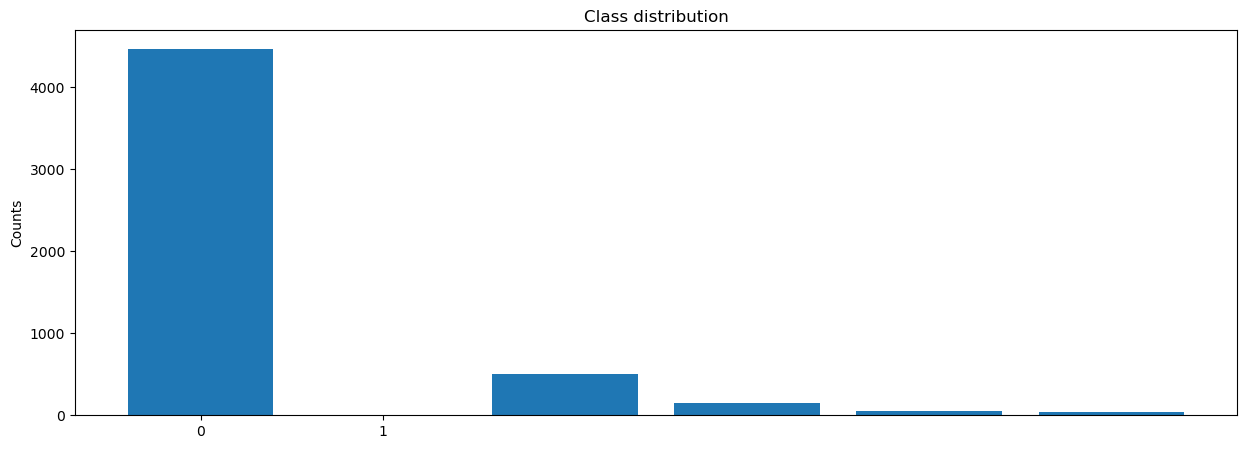

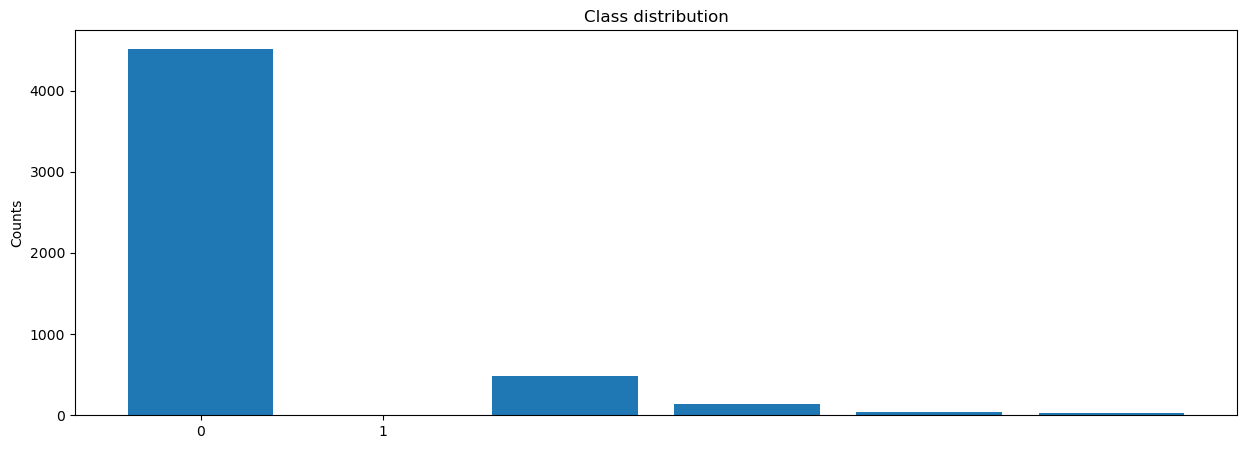

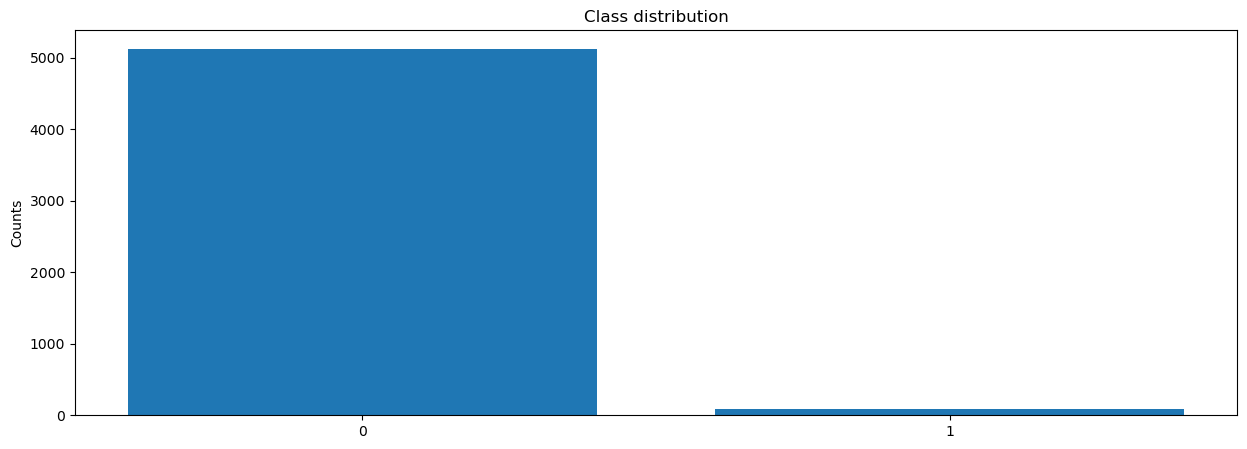

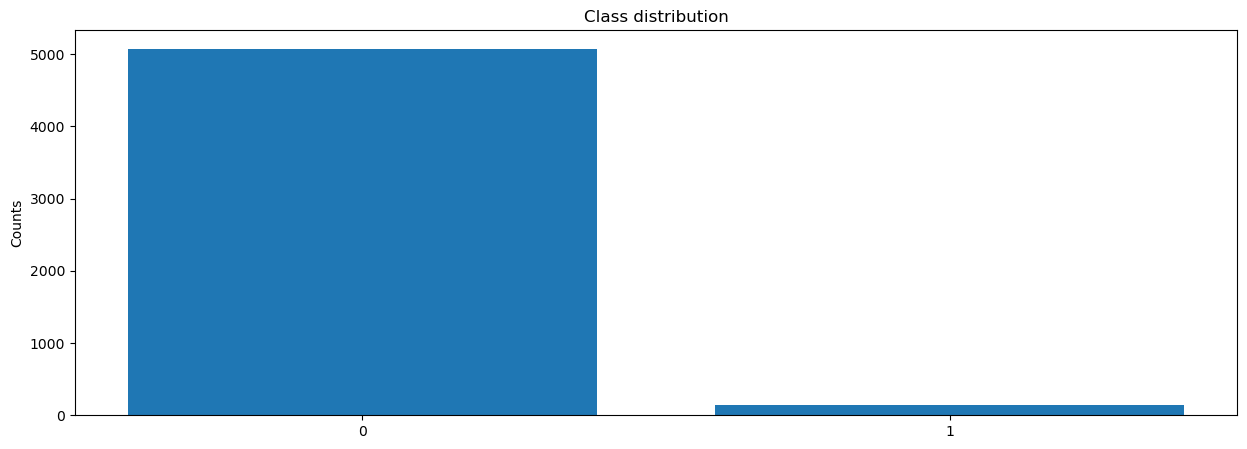

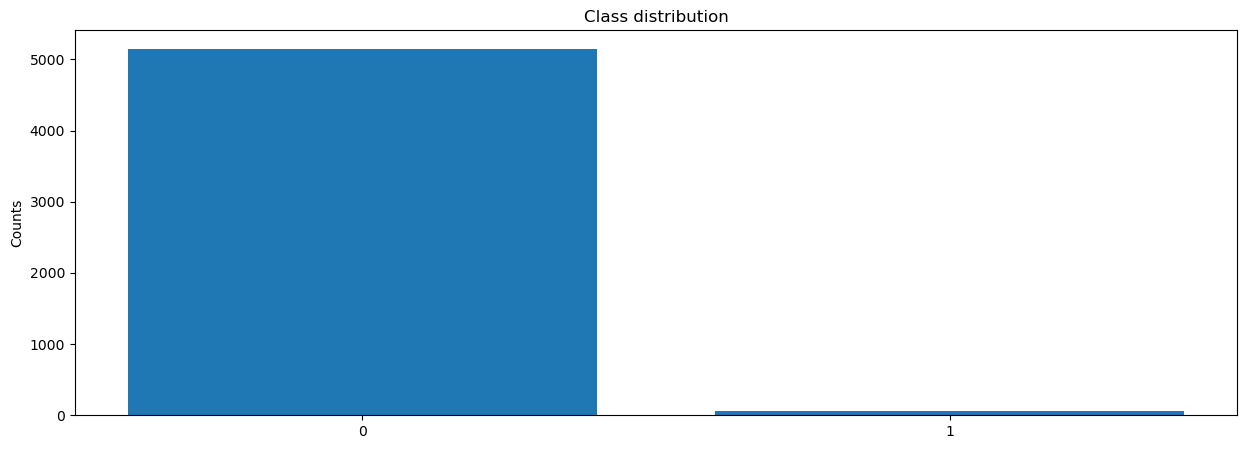

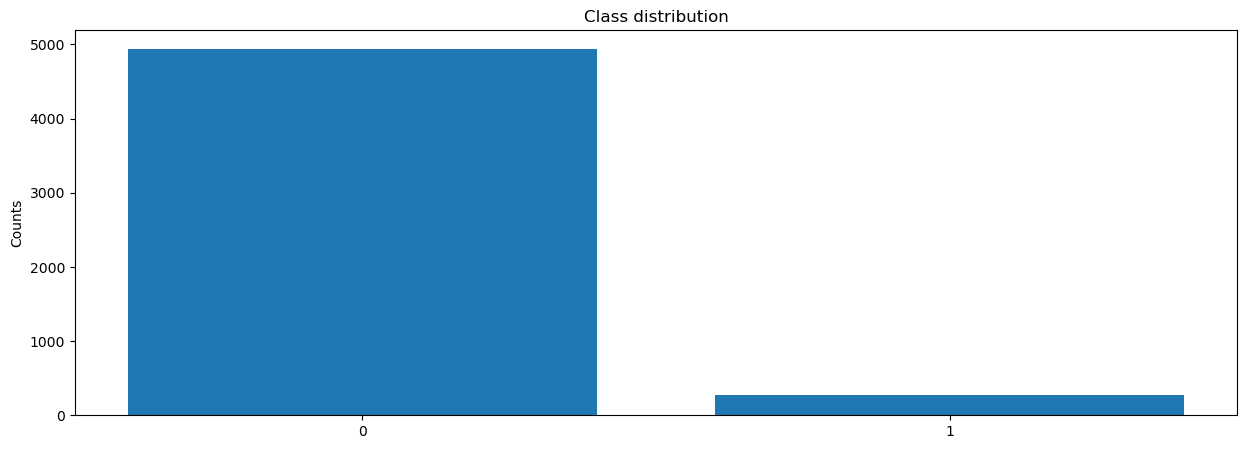

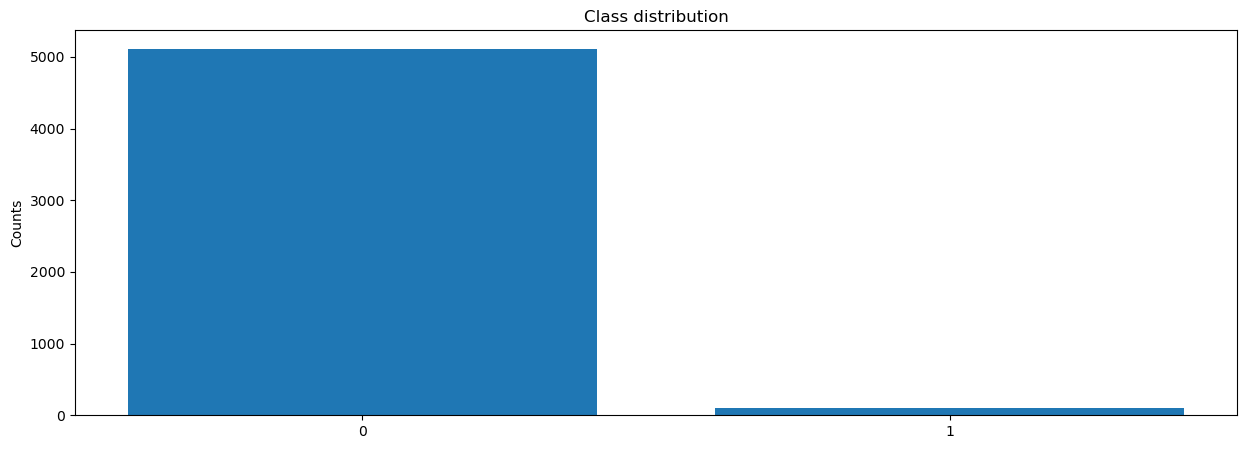

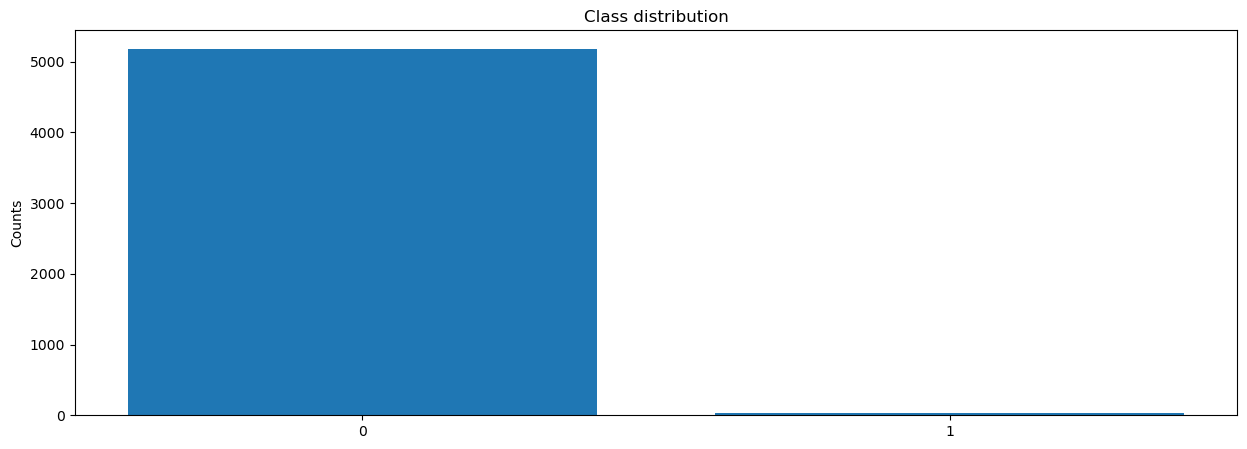

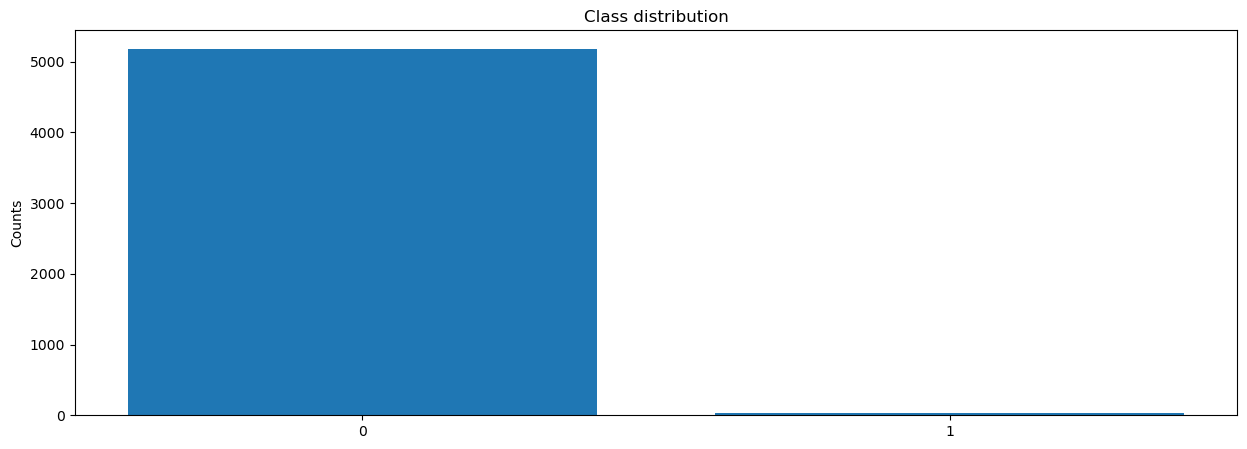

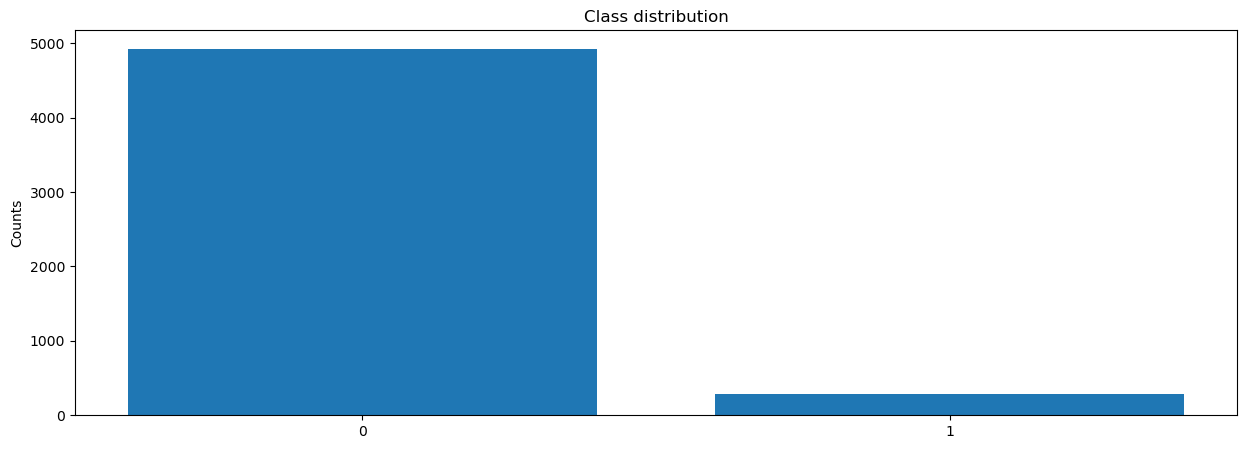

In [92]:
#visualise class imbalances
for column in labels.columns :
    unique_labels = np.sort(pd.unique(labels[column]))
    counts = np.unique(labels[column], return_counts = True)
    plt.figure(figsize = (15, 5))
    plt.bar(counts[0], counts[1])

    plt.title("Class distribution")
    plt.ylabel("Counts")
    plt.xticks((0,1), ['0', '1'])

    plt.show()

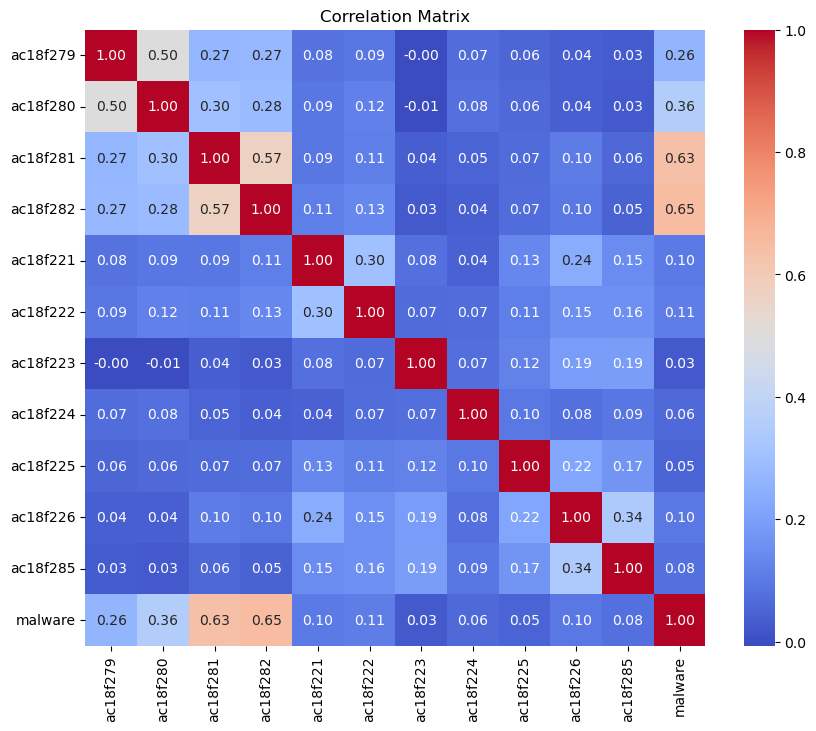

In [93]:
#correlation matrix of labels
correlation_matrix = labels.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

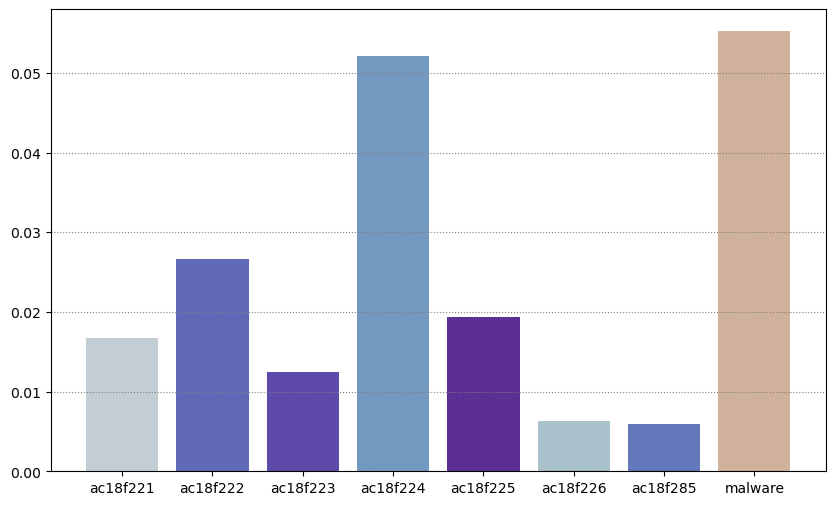

In [64]:
#Create label ratio imbalance 
labels_8 = labels[['ac18f221', 'ac18f222',	'ac18f223',	'ac18f224',	'ac18f225',	'ac18f226',	'ac18f285', 'malware']]
ratio_list = []

for label in labels_8 :
    ratio_list.append(labels_8[label].sum()/len(labels_8))

color_map = plt.cm.twilight

colors = color_map(np.random.rand(8))

fig, ax = plt.subplots(figsize = (10,6))
ax.bar(labels_8.columns, ratio_list, color = colors)
plt.grid(True, which= 'both', axis='y', linestyle = ':', color='gray')
plt.show()


### Multi-label classification with 8 labels

In [94]:
labels_8 = labels[['ac18f221', 'ac18f222',	'ac18f223',	'ac18f224',	'ac18f225',	'ac18f226',	'ac18f285', 'malware']]
X_train, X_test, y_train, y_test = train_test_split(parameters, labels_8, test_size=0.2, random_state=random_state)
y_train.head()

ac18f221  ac18f222  ac18f223  ac18f224  ac18f225  ac18f226  ac18f285  \
927        0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2499       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
45         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1741       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2275       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

      malware  
927         0  
2499        0  
45          0  
1741        0  
2275        0

### MLSMOTE

In [240]:
#MLSMOTE
import numpy as np
import pandas as pd
import random
from sklearn.neighbors import NearestNeighbors

def get_tail_label(df):
    """
    Give tail label colums of the given target dataframe
    
    args
    df: pandas.DataFrame, target label df whose tail label has to identified
    
    return
    tail_label: list, a list containing column name of all the tail label
    """
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    return tail_label

def get_index(df):
  """
  give the index of all tail_label rows
  args
  df: pandas.DataFrame, target label df from which index for tail label has to identified
    
  return
  index: list, a list containing index number of all the tail label
  """
  tail_labels = get_tail_label(df)
  index = set()
  for tail_label in tail_labels:
    sub_index = set(df[df[tail_label]==1].index)
    index = index.union(sub_index)
  return list(index)

def get_minority_instace(X, y):
    """
    Give minority dataframe containing all the tail labels
    
    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe
    
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    index = get_index(y)
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X):
    """
    Give index of 5 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs=NearestNeighbors(n_neighbors=5,metric='euclidean',algorithm='kd_tree').fit(X)
    euclidean,indices= nbs.kneighbors(X)
    return indices

def MLSMOTE(X,y, n_sample):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0,n-1)
        neighbour = random.choice(indices2[reference,1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val>2 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbour,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    new_X = pd.concat([X, new_X], axis=0)
    target = pd.concat([y, target], axis=0)
    return new_X, target

if __name__=='__main__':
    """
    main function to use the MLSMOTE
    """
    X_sub, y_sub = get_minority_instace(X_train, y_train)   #Getting minority instance of that datframe
    X_res,y_res =MLSMOTE(X_sub, y_sub, 1000)     #Applying MLSMOTE to augment the dataframe

In [242]:
#MLSMOTE logistic regression

classifier = LabelPowerset(LogisticRegression(max_iter=3000))

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_res, y_res)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = predictions
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.13984674329501914
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00        29
           2       0.02      0.92      0.04        12
           3       0.02      0.02      0.02        49
           4       0.06      0.13      0.08        23
           5       0.01      0.14      0.01         7
           6       0.01      0.22      0.03         9
           7       0.40      0.07      0.12        57

   micro avg       0.02      0.11      0.04       201
   macro avg       0.07      0.19      0.04       201
weighted avg       0.13      0.11      0.05       201
 samples avg       0.02      0.02      0.01       201



c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [116]:
#lpros logistic regression
classifier = LogisticRegression(max_iter=3000)

#Randomoversampler for the data
lp = LabelPowerset()
ros = RandomOverSampler(random_state=random_state)

yt = lp.transform(y_train)

X_resampled, y_resampled = ros.fit_resample(X_train, yt)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = lp.inverse_transform(predictions)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.22030651340996169
Classification Report:
              precision    recall  f1-score   support

           0       0.01      0.13      0.03        15
           1       0.03      0.17      0.05        29
           2       0.00      0.00      0.00        12
           3       0.08      0.37      0.13        49
           4       0.03      0.13      0.05        23
           5       0.03      0.14      0.04         7
           6       0.00      0.00      0.00         9
           7       0.07      0.25      0.11        57

   micro avg       0.04      0.21      0.07       201
   macro avg       0.03      0.15      0.05       201
weighted avg       0.05      0.21      0.08       201
 samples avg       0.03      0.04      0.03       201



c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [115]:
#LPROS with random forest
classifier = RandomForestClassifier(n_estimators=1000, random_state=42)

#Randomoversampler for the data
lp = LabelPowerset()
ros = RandomOverSampler(random_state=42)

yt = lp.transform(y_train)

X_resampled, y_resampled = ros.fit_resample(X_train, yt)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = lp.inverse_transform(predictions)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.8496168582375478
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00        29
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00        49
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        57

   micro avg       0.00      0.00      0.00       201
   macro avg       0.00      0.00      0.00       201
weighted avg       0.00      0.00      0.00       201
 samples avg       0.00      0.00      0.00       201



In [44]:
#MLkNN with LPROS
classifier = MLkNN(k=8)

#Randomoversampler for the data
lp = LabelPowerset()
ros = RandomOverSampler(random_state=42)

yt = lp.transform(y_train)

X_resampled, y_resampled = ros.fit_resample(X_train, yt)

from scipy.sparse import csr_matrix
X_sparse = csr_matrix(X_resampled)
y_sparse = csr_matrix(y_resampled)

X_train_np = X_train.to_numpy().astype(np.float32)  # Ensuring the data type for features
y_train_np = y_train.to_numpy().astype(int)         # Ensuring the labels are integers if necessary

classifier.fit(X=X_sparse, y=y_sparse)

y_pred = classifier.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

KeyboardInterrupt: 

In [118]:
#Multi-label multi perceptron
from scikeras.wrappers import KerasClassifier

X_train, X_test, y_train, y_test = train_test_split(parameters, labels_8, test_size=0.2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

def create_model(input_shape):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(8, activation='sigmoid')  # Assuming 8 output labels for multi-label classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['f1_score'])
    return model

classifier = KerasClassifier(build_fn=create_model, model__input_shape=X_train.shape[1], epochs=20, batch_size=32, verbose=0)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Since the output is sigmoid, we need to threshold it to get binary labels

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_25" is incompatible with the layer: expected axis -1 of input shape to have value 48, but received input with shape (None, 104)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 104), dtype=float32)
  • training=True
  • mask=None

### Multi-label classification with the deliton of 226 and 285 - 6 labels in total

In [119]:
labels_6 = labels[['ac18f221', 'ac18f222',	'ac18f223',	'ac18f224',	'ac18f225', 'malware']]
X_train, X_test, y_train, y_test = train_test_split(parameters, labels_6, test_size=0.2, random_state=random_state)
X_train.head()

geslacht  leeftijd  aantalki  oplcat  ac18f092  ac18f007  ac18f036  \
927          0      72.0         0       4         1         8       3.0   
2499         0      38.0         1       4         1         1       2.0   
45           1      47.0         3       5         2         1      10.0   
1741         0      63.0         0       6         1         1       2.0   
2275         0      33.0         0       4         1         1       4.0   

      ac18f045  ac18f047  ac18f048  ...  cs17j261  cs17j262  cs17j263  \
927        1.0       2.0       5.0  ...         0         0         0   
2499       2.0       3.0       3.0  ...         1         1         0   
45         2.0       4.0       2.0  ...         0         0         0   
1741       2.0       3.0       3.0  ...         0         1         0   
2275       2.0       5.0       3.0  ...         0         0         0   

      cs17j431  cs17j432  cs17j486  cs17j264  cs17j435  cs17j265  cs17j266  
927          0         0         0         0         0         0         0  
2499         0         0         0         0         0         0         0  
45           1         1         0         1         0         0         0  
1741         0         0         1         1         0         0         1  
2275         1         1         1         1         0         0         1  

[5 rows x 48 columns]

In [120]:
#lpros logistic regression
classifier = LogisticRegression()

#Randomoversampler for the data
lp = LabelPowerset()
ros = RandomOverSampler(random_state=42)

yt = lp.transform(y_train)

X_resampled, y_resampled = ros.fit_resample(X_train, yt)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = lp.inverse_transform(predictions)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.10440613026819924
Classification Report:
              precision    recall  f1-score   support

           0       0.01      0.13      0.01        15
           1       0.01      0.14      0.02        29
           2       0.01      0.25      0.03        12
           3       0.07      0.39      0.12        49
           4       0.02      0.22      0.04        23
           5       0.07      0.26      0.11        57

   micro avg       0.03      0.26      0.06       185
   macro avg       0.03      0.23      0.06       185
weighted avg       0.05      0.26      0.08       185
 samples avg       0.03      0.04      0.03       185



c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Multi-label classification with 4 of the labels. 
Deletion of 221 and 223

In [121]:
labels_4 = labels[['ac18f222', 'ac18f224',	'ac18f225', 'malware']]
X_train, X_test, y_train, y_test = train_test_split(parameters, labels_4, test_size=0.2, random_state=random_state)
y_train.head()

ac18f222  ac18f224  ac18f225  malware
927        0.0       0.0       0.0        0
2499       0.0       0.0       0.0        0
45         0.0       0.0       0.0        0
1741       0.0       0.0       0.0        0
2275       0.0       0.0       0.0        0

In [122]:
#lpros logistic regression
classifier = LogisticRegression(max_iter=600)

#Randomoversampler for the data
lp = LabelPowerset()
ros = RandomOverSampler(random_state=42)

yt = lp.transform(y_train)

X_resampled, y_resampled = ros.fit_resample(X_train, yt)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = lp.inverse_transform(predictions)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.27586206896551724
Classification Report:
              precision    recall  f1-score   support

           0       0.03      0.21      0.05        29
           1       0.07      0.39      0.12        49
           2       0.01      0.13      0.03        23
           3       0.06      0.28      0.10        57

   micro avg       0.05      0.28      0.08       158
   macro avg       0.04      0.25      0.07       158
weighted avg       0.05      0.28      0.09       158
 samples avg       0.03      0.04      0.03       158



c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [123]:
#LPros with randomforests
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

#Randomoversampler for the data
lp = LabelPowerset()
ros = RandomOverSampler(random_state=42)

yt = lp.transform(y_train)

X_resampled, y_resampled = ros.fit_resample(X_train, yt)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = lp.inverse_transform(predictions)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.8687739463601533
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.00      0.00      0.00        49
           2       0.00      0.00      0.00        23
           3       0.67      0.04      0.07        57

   micro avg       0.67      0.01      0.02       158
   macro avg       0.17      0.01      0.02       158
weighted avg       0.24      0.01      0.02       158
 samples avg       0.00      0.00      0.00       158



### Only two labels. 
Cybercrime victim and malware

In [125]:
#create new column
labels['victim'] = labels[['ac18f221', 'ac18f222',	'ac18f223',	'ac18f224',	'ac18f225',	'ac18f226',	'ac18f285']].sum(axis= 1)

labels['victim'] = labels['victim'].apply(lambda x: 1 if x >= 1 else x)

y = labels["victim"]
print(y.value_counts())

victim
0.0    4639
1.0     577
Name: count, dtype: int64


C:\Users\samsm\AppData\Local\Temp\ipykernel_7624\3579921424.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['victim'] = labels[['ac18f221', 'ac18f222',	'ac18f223',	'ac18f224',	'ac18f225',	'ac18f226',	'ac18f285']].sum(axis= 1)
C:\Users\samsm\AppData\Local\Temp\ipykernel_7624\3579921424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['victim'] = labels['victim'].apply(lambda x: 1 if x >= 1 else x)


In [126]:
#select two labels
labels_2 = labels[['malware', 'victim']]
labels_2.head()

malware  victim
0        0     0.0
1        0     0.0
2        0     0.0
3        0     0.0
4        0     0.0

In [177]:
#split data
X_train, X_test, y_train, y_test = train_test_split(parameters, labels_2, test_size=0.2, stratify= labels_2, random_state=random_state)
y_train.head()

malware  victim
976         0     0.0
604         0     0.0
17          0     1.0
1726        0     0.0
5028        0     1.0

In [178]:
#lpros logistic regression
classifier = LogisticRegression(max_iter=5000)

#Randomoversampler for the data
lp = LabelPowerset()
ros = RandomOverSampler(random_state=42)

yt = lp.transform(y_train)

X_resampled, y_resampled = ros.fit_resample(X_train, yt)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = lp.inverse_transform(predictions)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.4166666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.41      0.12        58
           1       0.14      0.47      0.21       116

   micro avg       0.10      0.45      0.17       174
   macro avg       0.10      0.44      0.16       174
weighted avg       0.11      0.45      0.18       174
 samples avg       0.06      0.07      0.06       174



In [179]:
#LPros with randomforests
classifier = RandomForestClassifier(n_estimators=1000, random_state=42)

#Randomoversampler for the data
lp = LabelPowerset()
ros = RandomOverSampler(random_state=42)

yt = lp.transform(y_train)

X_resampled, y_resampled = ros.fit_resample(X_train, yt)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = lp.inverse_transform(predictions)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.8467432950191571
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        58
           1       0.00      0.00      0.00       116

   micro avg       0.00      0.00      0.00       174
   macro avg       0.00      0.00      0.00       174
weighted avg       0.00      0.00      0.00       174
 samples avg       0.00      0.00      0.00       174



In [184]:
#multi label perceptron for two labels

X_train, X_test, y_train, y_test = train_test_split(parameters, labels_2, test_size=0.2, stratify= labels_2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

def create_model():
    model = models.Sequential([
        layers.Dense(256, activation='relu', input_shape=(103,)),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(2, activation='sigmoid')  # Assuming 8 output labels for multi-label classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['f1_score'])
    return model

classifier = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=1)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Since the output is sigmoid, we need to threshold it to get binary labels

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Epoch 1/20


c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - f1_score: 0.1432 - loss: 0.3759
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.1339 - loss: 0.2644
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.1070 - loss: 0.2689
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.1276 - loss: 0.2742
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.1727 - loss: 0.2795
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.1956 - loss: 0.2532
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.1940 - loss: 0.2625
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.1915 - loss: 0.2761
Epoch 9/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.2151 - loss: 0.2496
Epoch 10/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.2131 - loss: 0.2584
Epoch 11/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.2574 - loss: 0.2375
Epoch 12/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.2255 - loss: 0.2512


## With label 224 and malware

In [32]:
labels_2 = labels_8[['ac18f224', 'malware']]
X_train, X_test, y_train, y_test = train_test_split(parameters, labels_2, test_size=0.2, stratify= labels_2, random_state=random_state)
y_train.head()

ac18f224  malware
809        0.0        0
2095       1.0        0
4325       0.0        0
4316       0.0        0
5094       0.0        0

In [41]:
#lpros logistic regression -> try to optimalize this
classifier = LogisticRegression(solver= "liblinear", max_iter= 5000, C=1, penalty='l2')

#Randomoversampler for the data
lp = LabelPowerset()
ros = RandomOverSampler(random_state=42)

yt = lp.transform(y_train.values)

X_resampled, y_resampled = ros.fit_resample(X_train, yt)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = lp.inverse_transform(predictions)
y_pred_df = pd.DataFrame(y_pred.toarray(), columns=y_train.columns)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_df)
print("Accuracy:", accuracy)

f1_macro = f1_score(y_test, y_pred_df, average='macro')
print(f1_macro)

Accuracy: 0.4339080459770115
0.13546648986829574


In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

#gridserach
classifier = LogisticRegression(solver= "liblinear", max_iter= 5000)

#Randomoversampler for the data
lp = LabelPowerset()
ros = RandomOverSampler(random_state=42)

yt = lp.transform(y_train)

X_resampled, y_resampled = ros.fit_resample(X_train, yt)

#crete parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='f1_weighted', verbose= 1)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('grid_search', grid_search)
])

pipeline.fit(X_train, yt)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (macro F1): {:.2f}".format(grid_search.best_score_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'C': 1, 'penalty': 'l2'}
Best cross-validation score (macro F1): 0.85


In [40]:
print(predictions)

[0 0 1 ... 3 1 0]


### binary task for malware

In [133]:
# select malware label
malware = labels['malware']
X_train, X_test, y_train, y_test = train_test_split(parameters, malware, test_size=0.2, stratify= malware, random_state=random_state)
y_train.head()

4449    0
4478    0
461     0
561     1
4105    0
Name: malware, dtype: int32

In [136]:
#lpros logistic regression
classifier = LogisticRegression(max_iter=5000)

#Randomoversampler for the data
ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = predictions
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1score = f1_score(y_test, y_pred)
print("F1 Score:", f1score)

Accuracy: 0.7155172413793104
F1 Score: 0.17270194986072424


In [153]:
#lpros RF
classifier = RandomForestClassifier(n_estimators=1000, random_state=random_state)

#Randomoversampler for the data
ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = np.round(predictions)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1score = f1_score(y_test, y_pred)
print("F1 Score:", f1score)

Accuracy: 0.946360153256705
F1 Score: 0.0967741935483871


In [156]:
# random oversampler with svm
classifier = svm.SVC()

#Randomoversampler for the data
ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = np.round(predictions)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1score = f1_score(y_test, y_pred)
print("F1 Score:", f1score)

Accuracy: 0.7174329501915708
F1 Score: 0.16901408450704225


### binary with victim as column
This excludes malware victimisatino

In [163]:
victim = labels['victim']
X_train, X_test, y_train, y_test = train_test_split(parameters, victim, test_size=0.2, stratify= victim, random_state=random_state)
y_train.head()

721     0.0
2014    0.0
4042    1.0
1033    1.0
558     0.0
Name: victim, dtype: float64

In [164]:
#lpros logistic regression
classifier = LogisticRegression(max_iter=5000)

#Randomoversampler for the data
ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = predictions
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1score = f1_score(y_test, y_pred)
print("F1 Score:", f1score)

Accuracy: 0.6293103448275862
F1 Score: 0.2684310018903592


In [165]:
#lpros RF
classifier = RandomForestClassifier(n_estimators=100, random_state=random_state)

#Randomoversampler for the data
ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = np.round(predictions)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1score = f1_score(y_test, y_pred)
print("F1 Score:", f1score)

Accuracy: 0.8908045977011494
F1 Score: 0.017241379310344827


In [166]:
# random oversampler with svm
classifier = svm.SVC()

#Randomoversampler for the data
ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = np.round(predictions)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1score = f1_score(y_test, y_pred)
print("F1 Score:", f1score)

Accuracy: 0.5488505747126436
F1 Score: 0.22148760330578512


### Binary of victimisation including malware victimisation

In [54]:
labels['all'] = labels[['ac18f221', 'ac18f222',	'ac18f223',	'ac18f224',	'ac18f225',	'ac18f226',	'ac18f285', 'malware']].sum(axis= 1)

labels['all'] = labels['all'].apply(lambda x: 1 if x >= 1 else x)

y = labels["all"]
print(y.value_counts())

all
0.0    4423
1.0     793
Name: count, dtype: int64


C:\Users\samsm\AppData\Local\Temp\ipykernel_20992\190243359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['all'] = labels[['ac18f221', 'ac18f222',	'ac18f223',	'ac18f224',	'ac18f225',	'ac18f226',	'ac18f285', 'malware']].sum(axis= 1)
C:\Users\samsm\AppData\Local\Temp\ipykernel_20992\190243359.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['all'] = labels['all'].apply(lambda x: 1 if x >= 1 else x)


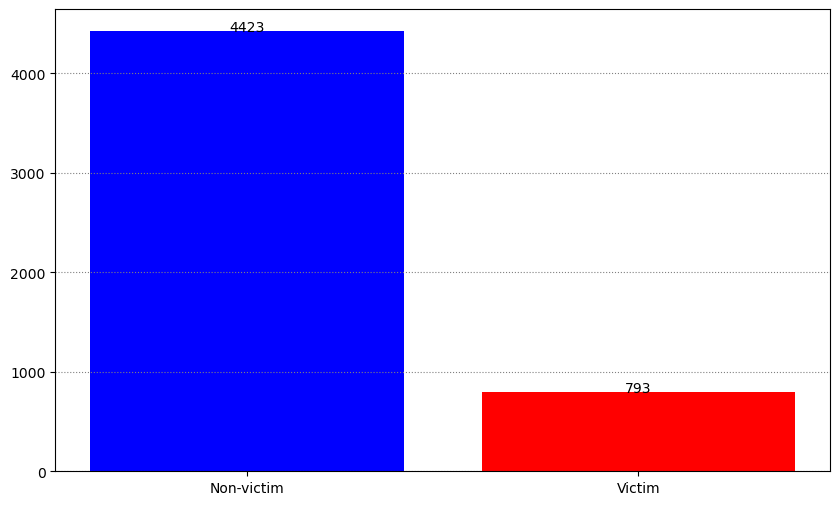

In [61]:
#create imbalance ratio chart for binary task
#add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

fig, ax = plt.subplots(figsize = (10,6))
ax.bar(x = ['Non-victim', 'Victim'], height = y.value_counts(), color = ['blue', 'red'])
addlabels(x = ['Non-victim', 'Victim'], y = y.value_counts())
plt.grid(True, which= 'both', axis='y', linestyle = ':', color='gray')
plt.show()


In [96]:
#save binary dataset
df = pd.concat([parameters, y], axis = 1)
df.to_csv('binary_task.csv', index=False)

In [2]:
#load binary dataset and onehotencode certain parameters
df = pd.read_csv('binary_task.csv')
print(df.head())

parameters = df.drop('all', axis=1)
y = df['all']

onehot_cols = ['ac18f092', 'ac18f007', 'ac18f045', 'ac18f066', 'ac18f067', 'ac18f069', 'ac18f070', 'ac18f071', 'ac18f080', 'ac18f081', 'ac18f082', 'ac18f083', 'ac18f084', 'ac18f085', 'ac18f087', 'ac18f088', 'ac18f089', 'ac18f090', 'ac18f091']

onehot = ce.OneHotEncoder(cols= onehot_cols)

parameters = onehot.fit_transform(parameters)

   geslacht  leeftijd  aantalki  oplcat  ac18f092  ac18f007  ac18f036  \
0         0      62.0         0       5         1         3      10.0   
1         0      55.0         2       6         1         1       6.0   
2         1      42.0         2       3         2         1       8.0   
3         1      71.0         0       2         1         4       1.0   
4         0      43.0         3       6         3         1       9.0   

   ac18f045  ac18f047  ac18f048  ...  cs17j262  cs17j263  cs17j431  cs17j432  \
0       2.0       3.0       3.0  ...         1         1         1         1   
1       2.0       4.0       2.0  ...         1         0         1         1   
2       4.0       4.0       0.0  ...         1         0         1         0   
3       1.0       5.0       5.0  ...         1         1         1         0   
4       3.0       1.0       2.0  ...         1         1         1         1   

   cs17j486  cs17j264  cs17j435  cs17j265  cs17j266  all  
0         1         1

In [10]:
#EDA average age and gender proportion

#female = 1
gender_prop = parameters['geslacht'].sum(axis = 0)/len(parameters)

#average age calc
average_age = parameters['leeftijd'].median(axis = 0)

print(gender_prop)
print(average_age)

0.5366180981595092
54.0


In [3]:
X_train, X_test, y_train, y_test = train_test_split(parameters, y, test_size=0.2, stratify= y, random_state=random_state)
X_train.head()

geslacht  leeftijd  aantalki  oplcat  ac18f092_1  ac18f092_2  \
4191         0      65.0         0       4           1           0   
509          1      54.0         2       5           0           1   
1344         0      17.0         2       1           0           0   
1825         1      44.0         3       5           0           1   
1071         1      71.0         0       2           1           0   

      ac18f092_3  ac18f092_4  ac18f092_5  ac18f092_6  ...  cs17j261  cs17j262  \
4191           0           0           0           0  ...         1         0   
509            0           0           0           0  ...         0         1   
1344           0           1           0           0  ...         0         0   
1825           0           0           0           0  ...         0         0   
1071           0           0           0           0  ...         0         0   

      cs17j263  cs17j431  cs17j432  cs17j486  cs17j264  cs17j435  cs17j265  \
4191         0         1         1         1         1         0         0   
509          0         0         0         0         1         0         1   
1344         1         1         0         0         1         0         0   
1825         0         1         0         0         1         0         0   
1071         0         0         0         0         1         0         0   

      cs17j266  
4191         1  
509          1  
1344         1  
1825         0  
1071         0  

[5 rows x 104 columns]

In [11]:
#evaluation metrics

def evalution(actual, predict, probabilities) :
    print("Accuracy:", accuracy_score(actual, predict))
    print("Binary F1:", f1_score(actual, predict, average = 'binary', pos_label= 1))
    print("Weighted F1", f1_score(actual, predict, average = 'weighted', pos_label= 1))
    print("Recall", recall_score(actual, predict))

    #confusion matrix
    confusion = confusion_matrix(actual, predict)
    matrix = ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels = ['Non-victim', 'Victim'])
    matrix.plot()
    plt.show()

    # ROC curve
    fpr, tpr, thresholds = roc_curve(actual, probabilities)

    # Calculate AUC (Area Under Curve)
    auc_score = roc_auc_score(actual, probabilities)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    

In [6]:
#Randomoversampling
ros = RandomOverSampler(random_state=42)

c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.85727969348659
Binary F1: 0.1286549707602339
Weighted F1 0.8014070621664157
Recall 0.06918238993710692


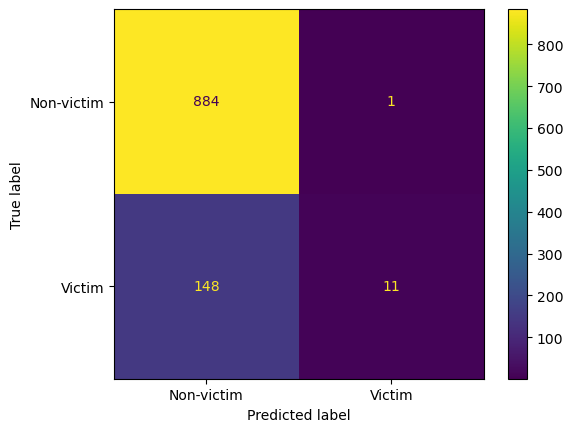

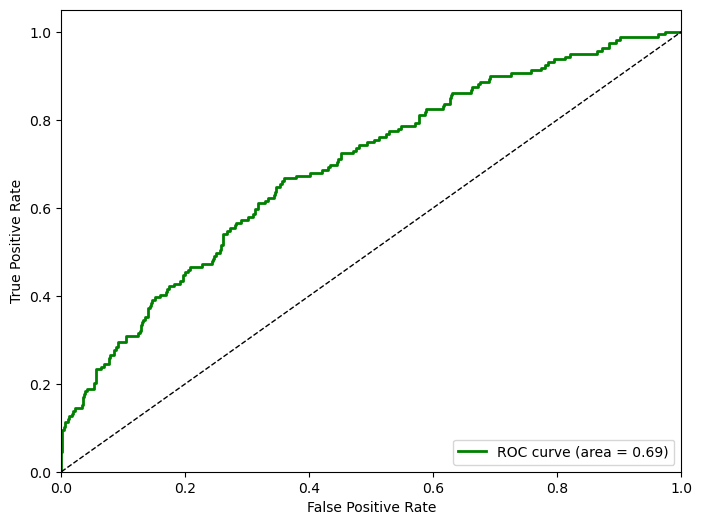

In [14]:
#simple logistic regression 
classifier = LogisticRegression()

# create pipeline
pipeline = IMBPipeline(steps=[
    ('classifier', classifier)
])

pipeline.fit(X_train, y_train)

# Make predictions on the test set
predictions = pipeline.predict(X_test)
probabilities = pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions

# eval metrics
evalution(y_test, y_pred, probabilities)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits


c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

{'classifier__C': 0.01, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'classifier__warm_start': True}
Accuracy: 0.6580459770114943
Binary F1: 0.34972677595628415
Weighted F1 0.7043239077741671
Recall 0.6037735849056604


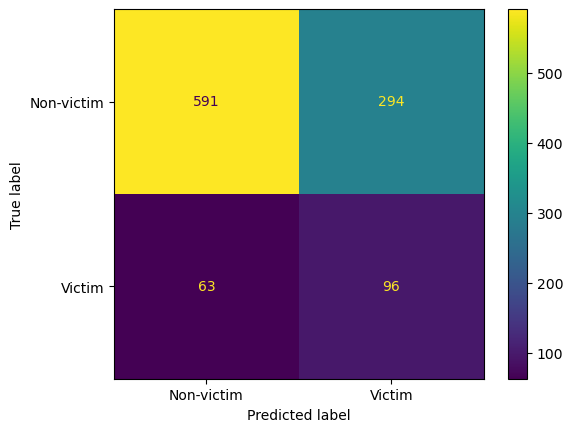

In [102]:
#Random oversampling wit logit  and gridsearch
classifier = LogisticRegression()

# create pipeline
pipeline = IMBPipeline(steps=[ 
    ('ros', ros),
    ('classifier', classifier)
])

param_grid = {
    'classifier__solver': ['lbfgs', 'newton-cg'],
    'classifier__penalty': ['none', 'l2'],
    'classifier__C' : [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
    'classifier__max_iter' : [100, 200, 300, 500],
    'classifier__warm_start' : [True, False]
}

skf = StratifiedKFold(n_splits=5)

# Grid search with pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring='f1', verbose = 1)
grid_search.fit(X_train, y_train)


# eval metrics
print(grid_search.best_params_)

# Make predictions on the test set
predictions = grid_search.predict(X_test)
probabilities = grid_search.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

[I 2024-05-11 21:30:40,408] A new study created in memory with name: no-name-52c20f70-c989-4b1d-9b27-ad9eccce0869
c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the

Best trial:
 Value: 0.32750003276734
 Params: 
    solver: newton-cg
    C: 0.002326262550820801
    max_iter: 500
    warm_start: False
Accuracy: 0.6484674329501916
Binary F1: 0.3504424778761062
Weighted F1 0.6968010927685101
Recall 0.6226415094339622


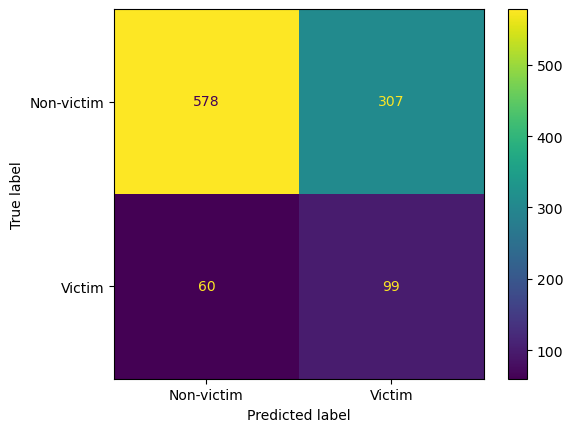

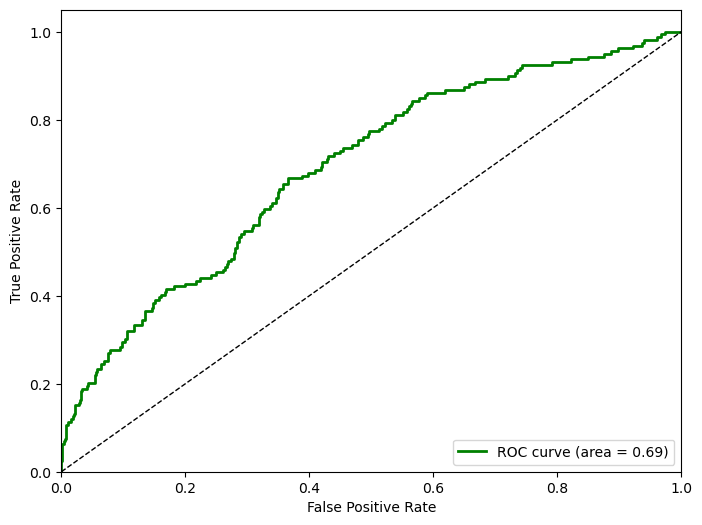

In [18]:
#optuna ros LR
def objective(trial):
    # Suggest values for the hyperparameters
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg'])
    C = trial.suggest_float('C', 1e-6, 1e-1, log = True)
    max_iter = trial.suggest_categorical('max_iter', [100, 200, 300, 500, 600, 700])
    warm_start = trial.suggest_categorical('warm_start', [True, False])

    # Create the classifier with suggested parameters
    classifier = LogisticRegression(solver=solver, C=C, max_iter=max_iter, warm_start=warm_start, random_state=random_state)
    
    # Create a pipeline
    pipeline = IMBPipeline([
        ('smote', ros),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=3)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
best_classifier = LogisticRegression(**best_params, random_state=random_state)
best_pipeline = IMBPipeline([
    ('smote', ros),
    ('classifier', best_classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

In [41]:
#lpros RF
classifier = RandomForestClassifier(n_estimators=1000, random_state=random_state)

#Randomoversampler for the data
ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = np.round(predictions)

# eval metrics
evalution(y_test, y_pred)

Accuracy: 0.853448275862069
Binary F1: 0.09467455621301775
Weighted F1 0.7945335889273588
Recall 0.050314465408805034


In [42]:
#rf gridsearch with random oversampling
classifier = RandomForestClassifier(random_state= random_state)

# create pipeline
pipeline = IMBPipeline(steps=[ 
    ('ros', ros),
    ('classifier', classifier)
])

param_grid = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__max_depth': [None, 10, 20, 30, 50],
    'classifier__min_samples_split' : [2, 5, 10],
    'classifier__min_samples_leaf' : [1, 2, 4],
    'classifier__max_features' : ['sqrt', 'log2', None],
    'classifier__criterion' : ['gini', 'entropy']
}

skf = StratifiedKFold(n_splits=5)

# Grid search with pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring='f1', verbose = 1, n_jobs=-1)
grid_search.fit(X_train, y_train)


# eval metrics
print(grid_search.best_params_)

# Make predictions on the test set
predictions = grid_search.predict(X_test)
probabilities = grid_search.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


KeyboardInterrupt: 

[I 2024-05-11 21:31:39,185] A new study created in memory with name: no-name-5e12cec1-2a49-44d3-b134-bc14e021196e
[I 2024-05-11 21:31:48,018] Trial 0 finished with value: 0.2343782160715799 and parameters: {'n_estimators': 500, 'max_depth': 60, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 0 with value: 0.2343782160715799.
[I 2024-05-11 21:32:16,953] Trial 1 finished with value: 0.24493399593842483 and parameters: {'n_estimators': 350, 'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': None, 'criterion': 'entropy'}. Best is trial 1 with value: 0.24493399593842483.
[I 2024-05-11 21:32:27,606] Trial 2 finished with value: 0.07365514875478088 and parameters: {'n_estimators': 500, 'max_depth': None, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 1 with value: 0.24493399593842483.
[I 2024-05-11 21:32:30,562] Trial 3 finished with value: 0

Best trial:
 Value: 0.31637395936240714
 Params: 
    n_estimators: 200
    max_depth: 30
    min_samples_split: 2
    min_samples_leaf: 20
    max_features: sqrt
    criterion: gini
Accuracy: 0.7394636015325671
Binary F1: 0.33658536585365856
Weighted F1 0.7615522771478588
Recall 0.4339622641509434


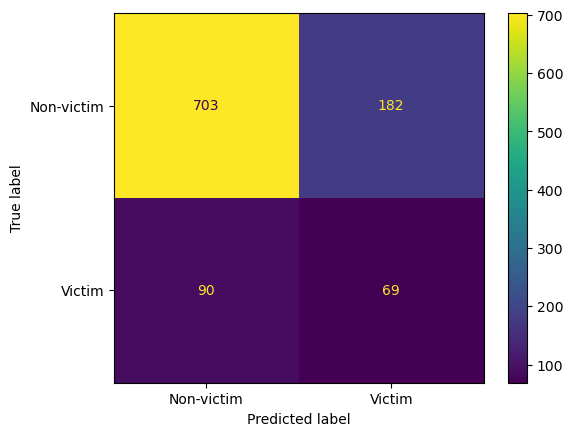

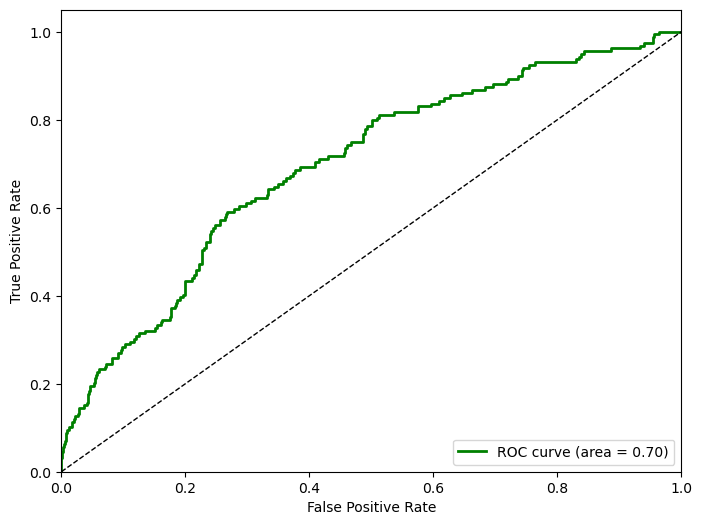

In [19]:
#optuna RF ros
def objective(trial):

    # parameter grid
    n_estimators = trial.suggest_int('n_estimators', 100, 600, step=50)
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30, 50, 60])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    # Setup the classifier
    classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        random_state=42
    )

    # Create a pipeline
    pipeline = IMBPipeline([
        ('smote', ros),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=3)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

#pruner = MedianPruner()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
classifier = RandomForestClassifier(**best_params, random_state=random_state)
best_pipeline = IMBPipeline([
    ('smote', ros),
    ('classifier', classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

In [107]:
# random oversampler with svm
classifier = svm.SVC()

#Randomoversampler for the data
ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# create pipeline
pipeline = IMBPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)
probabilities = pipeline.predict_proba(X_test)[:, 1]

y_pred = np.round(predictions)
# Calculate accuracy
# eval metrics
evalution(y_test, y_pred, probabilities)

Accuracy: 0.6193672099712368
Binary F1: 0.2998236331569665
Weighted F1 0.6721686831643783
Recall 0.5379746835443038


[I 2024-05-12 16:31:25,854] A new study created in memory with name: no-name-dd117ae1-b11f-49cc-829f-f47a1a14714f
[I 2024-05-12 16:31:31,329] Trial 0 finished with value: 0.19448058066898788 and parameters: {'kernel': 'sigmoid', 'C': 20.187987607415405, 'gamma': 'scale', 'coef0': 0.6469376547032952}. Best is trial 0 with value: 0.19448058066898788.
[I 2024-05-12 16:31:40,568] Trial 1 finished with value: 0.260706641036967 and parameters: {'kernel': 'sigmoid', 'C': 0.027925197326184478, 'gamma': 'auto', 'coef0': 0.7501146221152479}. Best is trial 1 with value: 0.260706641036967.
[I 2024-05-12 16:31:50,980] Trial 2 finished with value: 0.28955333877259 and parameters: {'kernel': 'rbf', 'C': 0.0013369487454177938, 'gamma': 'auto'}. Best is trial 2 with value: 0.28955333877259.
[I 2024-05-12 16:32:28,425] Trial 3 finished with value: 0.3122810437329542 and parameters: {'kernel': 'poly', 'C': 0.037882344568332234, 'gamma': 'auto', 'coef0': 0.3211496990986673}. Best is trial 3 with value: 0.

Best trial:
 Value: 0.3272977272260507
 Params: 
    kernel: linear
    C: 0.664311752509228
    gamma: scale
Accuracy: 0.646551724137931
Binary F1: 0.33273056057866185
Weighted F1 0.6945960065069398
Recall 0.5786163522012578


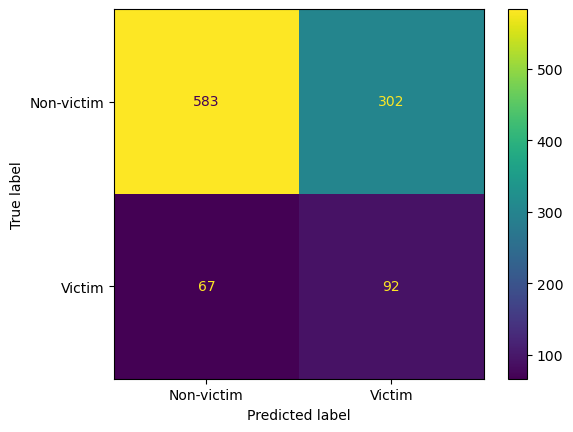

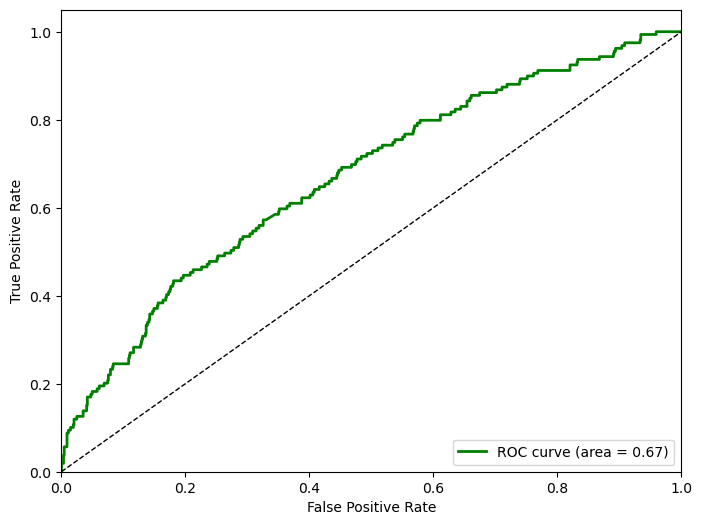

In [7]:
#optuna SVM ros
def objective(trial):
    # Suggest values for the hyperparameters
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid', 'poly'])
    C = trial.suggest_float('C', 1e-5, 1e2, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    # Additional parameters for 'poly' and 'sigmoid'
    coef0 = trial.suggest_float('coef0', 0, 1) if kernel in ['sigmoid', 'poly'] else 0.0

    # Create the SVM classifier
    classifier = svm.SVC(kernel=kernel, C=C, gamma=gamma, coef0=coef0, random_state=random_state)

    # Create a pipeline
    pipeline = IMBPipeline([
        ('smote', ros),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=3)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

#pruner = MedianPruner()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
classifier = svm.SVC(**best_params, probability=True, random_state=random_state)
best_pipeline = IMBPipeline([
    ('smote', ros),
    ('classifier', classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

In [38]:
#random oversampler with kNN
classifier = KNeighborsClassifier()

#Randomoversampler for the data
ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# create pipeline
pipeline = IMBPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)
probabilities = pipeline.predict_proba(X_test)[:, 1]

y_pred = np.round(predictions)
# eval metrics
evalution(y_test, y_pred, probabilities)

Accuracy: 0.6647509578544061
Binary F1: 0.24568965517241378
Weighted F1 0.7024251882679351
Recall 0.3584905660377358


[I 2024-05-10 19:34:26,915] A new study created in memory with name: no-name-f7357c13-7149-490a-b6a4-503bd035bb6d
[I 2024-05-10 19:34:32,697] Trial 0 finished with value: 0.2410483603771745 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 35, 'p': 1}. Best is trial 0 with value: 0.2410483603771745.
[I 2024-05-10 19:34:35,147] Trial 1 finished with value: 0.15565290664444553 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 50, 'p': 1}. Best is trial 0 with value: 0.2410483603771745.
[I 2024-05-10 19:34:37,125] Trial 2 finished with value: 0.24722655355029702 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'brute', 'leaf_size': 60, 'p': 2}. Best is trial 2 with value: 0.24722655355029702.
[I 2024-05-10 19:34:40,092] Trial 3 finished with value: 0.23665061844718013 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 35, 'p': 1}. Best is t

Best trial:
 Value: 0.2544024455786551
 Params: 
    n_neighbors: 9
    weights: uniform
    algorithm: kd_tree
    leaf_size: 50
    p: 2
Accuracy: 0.6091954022988506
Binary F1: 0.26618705035971224
Weighted F1 0.6624826005766019
Recall 0.46540880503144655


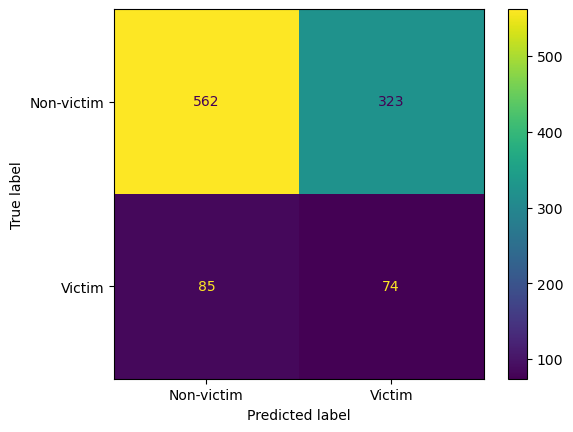

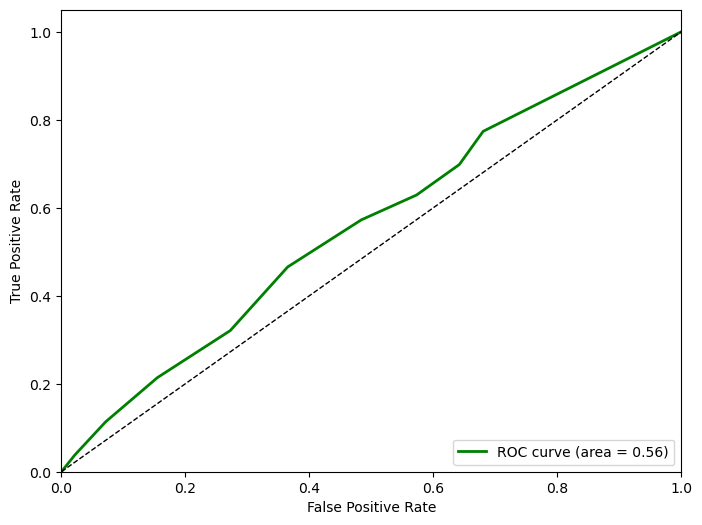

In [14]:
#knn ros optuna
def objective(trial):

    # parameter grid
    n_neighbors = trial.suggest_int('n_neighbors', 2, 10)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    leaf_size = trial.suggest_int('leaf_size', 20, 60, step=5)
    p = trial.suggest_categorical('p', [1, 2])

    # Set up the classifier
    classifier = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        leaf_size=leaf_size,
        p=p
    )

    # Create a pipeline
    pipeline = IMBPipeline([
        ('smote', ros),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=3)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

#pruner = MedianPruner()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
classifier = KNeighborsClassifier(**best_params)
best_pipeline = IMBPipeline([
    ('smote', ros),
    ('classifier', classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

Accuracy: 0.6091954022988506
Binary F1: 0.32
Weighted F1 0.6640025954764553
Recall 0.6037735849056604


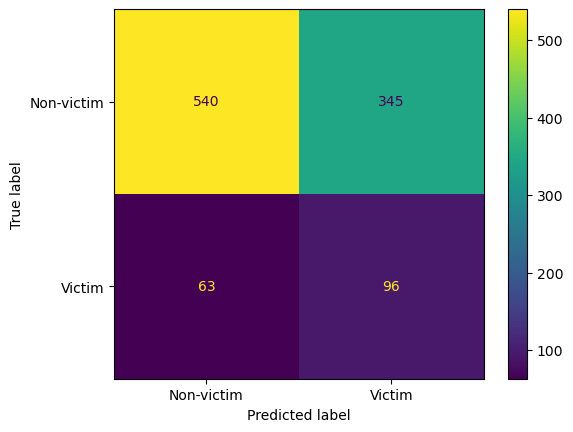

In [46]:
#bayes classifier
parameters_bayes = df.drop('all', axis=1)
y_bayes = df['all']

X_train_bayes, X_test_bayes, y_train_bayes, y_test_bayes = train_test_split(parameters_bayes, y_bayes, test_size=0.2, stratify= y_bayes, random_state=random_state)

classifier = MultinomialNB()

# create pipeline
pipeline = IMBPipeline(steps=[
    ('ros', ros),
    ('classifier', classifier)
])

pipeline.fit(X_train_bayes, y_train_bayes)

# Make predictions on the test set
predictions = pipeline.predict(X_test_bayes)

y_pred = predictions

# eval metrics
evalution(y_test_bayes, y_pred)

## Use of smote

In [9]:
#smote plus one hot encoder application

smote = SMOTENC(categorical_features = X_train.drop(['ac18f036', 'leeftijd', 'aantalki'], axis=1).columns.tolist(), random_state=42, sampling_strategy='auto')

X_smote, y_smote = smote.fit_resample(X_train, y_train)

print(X_smote.tail(20))

      geslacht   leeftijd  aantalki  oplcat  ac18f092_1  ac18f092_2  \
7056         0  29.121880         0       5           1           0   
7057         1  30.981725         0       6           1           0   
7058         0  59.712406         0       3           1           0   
7059         1  21.931351         1       3           0           0   
7060         1  69.000000         0       2           1           0   
7061         0  68.291619         0       4           1           0   
7062         1  45.137021         0       4           1           0   
7063         0  67.612754         0       5           1           0   
7064         0  18.554761         2       3           0           0   
7065         1  28.284466         0       2           1           0   
7066         1  45.122850         2       4           0           1   
7067         1  22.223925         1       3           0           0   
7068         1  44.726546         1       4           0           1   
7069  

Fitting 5 folds for each of 96 candidates, totalling 480 fits


c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
240 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\imblearn\pipeline

{'classifier__C': 0.0001, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'classifier__warm_start': True}
Accuracy: 0.592911877394636
Binary F1: 0.2975206611570248
Weighted F1 0.6500779455404178
Recall 0.5660377358490566


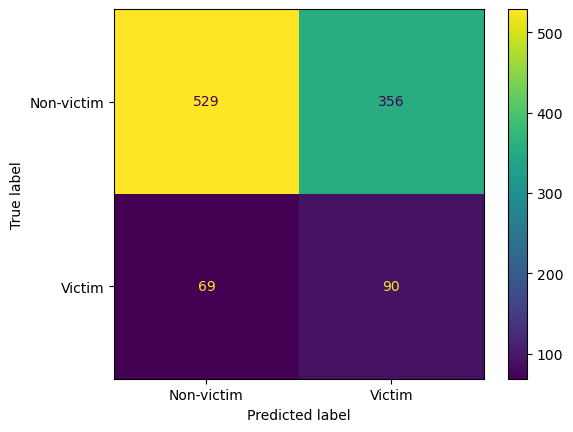

In [20]:
#gridsearchf for lR

classifier = LogisticRegression()

# create pipeline
pipeline = IMBPipeline(steps=[ 
    ('smote', smote),
    ('classifier', classifier)
])

param_grid = {
    'classifier__solver': ['lbfgs', 'newton-cg'],
    'classifier__penalty': ['none', 'l2'],
    'classifier__C' : [0.000001, 0.00001, 0.0001],
    'classifier__max_iter' : [100, 200, 300, 500],
    'classifier__warm_start' : [True, False]
}

skf = StratifiedKFold(n_splits=5)

# Grid search with pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring='accuracy', verbose = 1)
grid_search.fit(X_train, y_train)


# eval metrics
print(grid_search.best_params_)

# Make predictions on the test set
predictions = grid_search.predict(X_test)
probabilities = grid_search.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

{'classifier__C': 1e-05, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'classifier__warm_start': True}

Accuracy: 0.5977011494252874
Binary F1: 0.3
Weighted F1 0.6541203188728217
Recall 0.5660377358490566


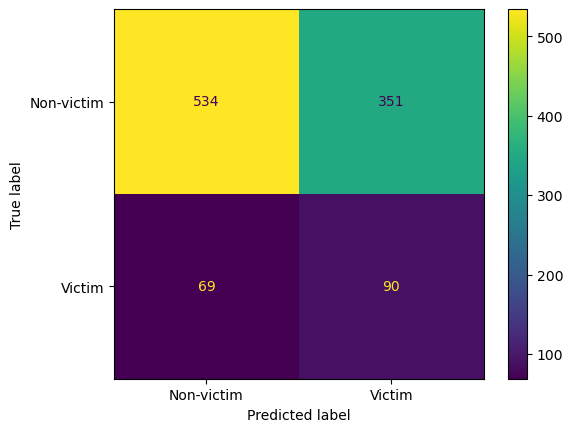

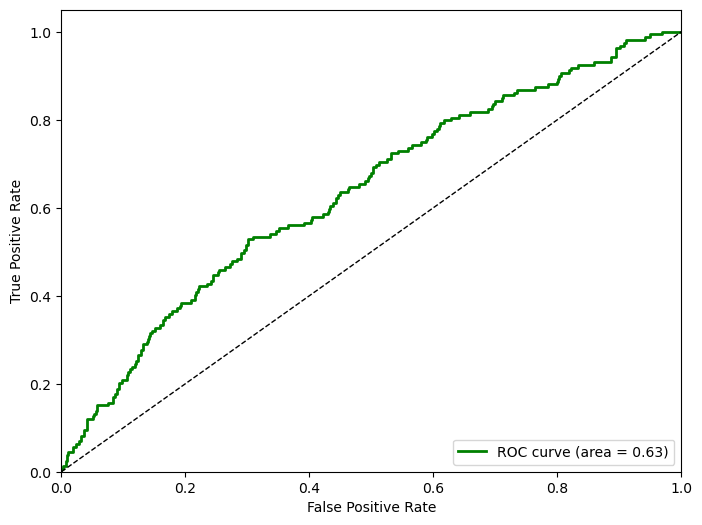

In [30]:
#logistic regression with smote
classifier = LogisticRegression(C=0.00001, max_iter=100, penalty= 'l2', solver='lbfgs', warm_start= True)

# create pipeline
pipeline = IMBPipeline(steps=[  
    ('smote', smote),
    ('classifier', classifier)
])

pipeline.fit(X_train, y_train)

# Make predictions on the test set
predictions = pipeline.predict(X_test)
probabilities = pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions

# eval metrics
evalution(y_test, y_pred, probabilities)

[I 2024-05-12 01:13:44,272] A new study created in memory with name: no-name-58494b26-a4da-42e5-81eb-3b12fa36578a
[I 2024-05-12 01:13:54,651] Trial 0 finished with value: 0.2676012257407918 and parameters: {'solver': 'newton-cg', 'C': 0.0035480302317158, 'max_iter': 700, 'warm_start': True}. Best is trial 0 with value: 0.2676012257407918.
[I 2024-05-12 01:14:04,813] Trial 1 finished with value: 0.2879284195784899 and parameters: {'solver': 'lbfgs', 'C': 0.00013672125327479225, 'max_iter': 500, 'warm_start': False}. Best is trial 1 with value: 0.2879284195784899.
[I 2024-05-12 01:14:15,085] Trial 2 finished with value: 0.2582330406748435 and parameters: {'solver': 'newton-cg', 'C': 0.027232988981340384, 'max_iter': 600, 'warm_start': True}. Best is trial 1 with value: 0.2879284195784899.
[I 2024-05-12 01:14:25,098] Trial 3 finished with value: 0.2958386142796789 and parameters: {'solver': 'newton-cg', 'C': 2.3866902246980717e-06, 'max_iter': 300, 'warm_start': False}. Best is trial 3 wi

Best trial:
 Value: 0.2979503583209339
 Params: 
    solver: newton-cg
    C: 1.740506992894724e-05
    max_iter: 700
    warm_start: False
Accuracy: 0.5996168582375478
Binary F1: 0.3010033444816054
Weighted F1 0.6557321494131613
Recall 0.5660377358490566


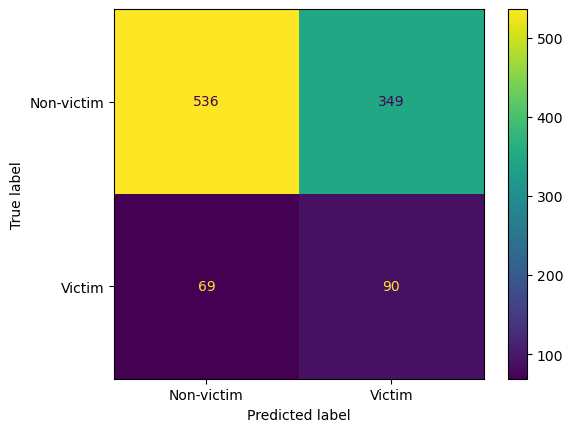

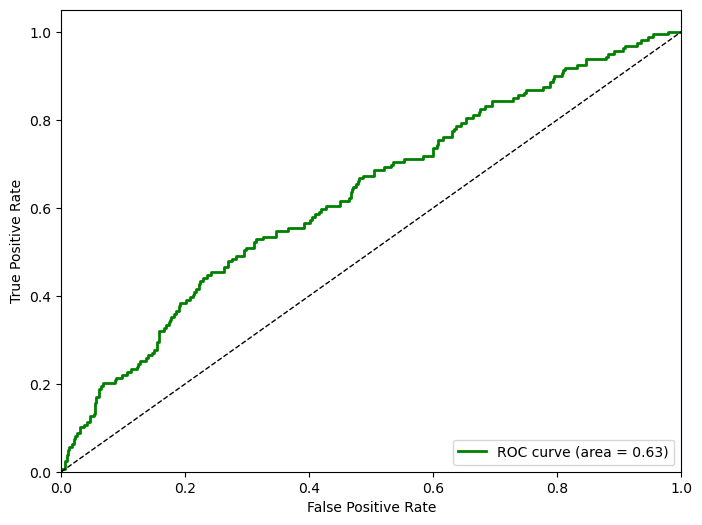

In [10]:
#LR with smote and optuna

def objective(trial):
    # Suggest values for the hyperparameters
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg'])
    C = trial.suggest_float('C', 1e-6, 1e-1, log = True)
    max_iter = trial.suggest_categorical('max_iter', [100, 200, 300, 500, 600, 700])
    warm_start = trial.suggest_categorical('warm_start', [True, False])

    # Create the classifier with suggested parameters
    classifier = LogisticRegression(solver=solver, C=C, max_iter=max_iter, warm_start=warm_start, random_state=random_state)
    
    # Create a pipeline
    pipeline = IMBPipeline([
        ('smote', smote),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=3)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
best_classifier = LogisticRegression(**best_params, random_state=random_state)
best_pipeline = IMBPipeline([
    ('smote', smote),
    ('classifier', best_classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

In [35]:
#RF with gridsearchcv
classifier = RandomForestClassifier(criterion= 'entropy', max_depth = 10, max_features= None, min_samples_leaf= 1, n_estimators= 300, random_state= random_state)

# create pipeline
pipeline = IMBPipeline(steps=[ 
    ('smote', smote),
    ('classifier', classifier)
])

param_grid = {
    'classifier__min_samples_split' : [5, 10, 15, 20, 30]
}

skf = StratifiedKFold(n_splits=5)

# Grid search with pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring='f1', verbose = 1, n_jobs=-1)
grid_search.fit(X_train, y_train)


# eval metrics
print(grid_search.best_params_)

# Make predictions on the test set
predictions = grid_search.predict(X_test)
probabilities = grid_search.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'classifier__min_samples_split': 10}
Accuracy: 0.7344199424736337
Binary F1: 0.25336927223719674
Weighted F1 0.7498472234433153
Recall 0.2974683544303797


First try at tuning. 
param_grid = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__max_depth': [None, 10, 20, 30, 50],
    'classifier__min_samples_split' : [2, 5, 10],
    'classifier__min_samples_leaf' : [1, 2, 4],
    'classifier__max_features' : ['sqrt', 'log2', None],
    'classifier__criterion' : ['gini', 'entropy']
}

Result:
{'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}

Accuracy: 0.7327586206896551
Binary F1: 0.2520107238605898
Weighted F1 0.7481761917249896
Recall 0.29559748427672955


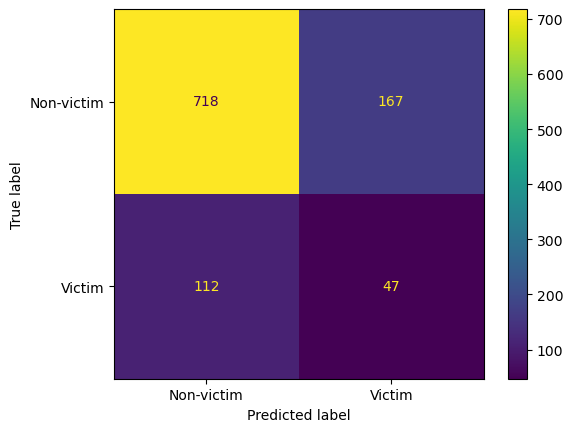

In [16]:
#Rf classifier
classifier = RandomForestClassifier(criterion= 'entropy', max_depth = 10, max_features= None, min_samples_leaf= 1, n_estimators= 300, min_samples_split=10, random_state= random_state)

# create pipeline
pipeline = IMBPipeline(steps=[
    ('smote', smote),
    ('classifier', classifier)
])

pipeline.fit(X_smote, y_smote)

# Make predictions on the test set
predictions = pipeline.predict(X_test)
probabilities = pipeline.predict_proba(X_test)[:, 1]

y_pred = np.round(predictions)

# eval metrics
evalution(y_test, y_pred, probabilities)

[I 2024-05-12 01:22:21,668] A new study created in memory with name: no-name-8c0c874f-6241-44a6-bffe-499980cb7df8
[I 2024-05-12 01:23:26,680] Trial 0 finished with value: 0.19973220723040477 and parameters: {'n_estimators': 600, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_features': None, 'criterion': 'entropy'}. Best is trial 0 with value: 0.19973220723040477.
[I 2024-05-12 01:23:47,631] Trial 1 finished with value: 0.23630594608043998 and parameters: {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 18, 'max_features': None, 'criterion': 'entropy'}. Best is trial 1 with value: 0.23630594608043998.
[I 2024-05-12 01:24:00,988] Trial 2 finished with value: 0.17814977230561646 and parameters: {'n_estimators': 200, 'max_depth': 50, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 1 with value: 0.23630594608043998.
[I 2024-05-12 01:24:55,436] Trial 3 finished with value:

Best trial:
 Value: 0.24065190423522723
 Params: 
    n_estimators: 150
    max_depth: 10
    min_samples_split: 2
    min_samples_leaf: 16
    max_features: None
    criterion: entropy
Accuracy: 0.7279693486590039
Binary F1: 0.21978021978021978
Weighted F1 0.7415289193831477
Recall 0.25157232704402516


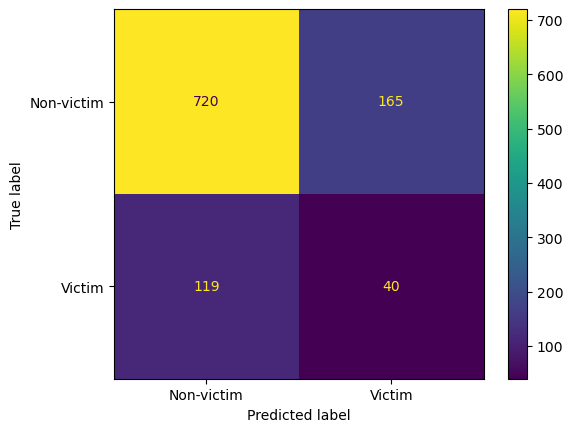

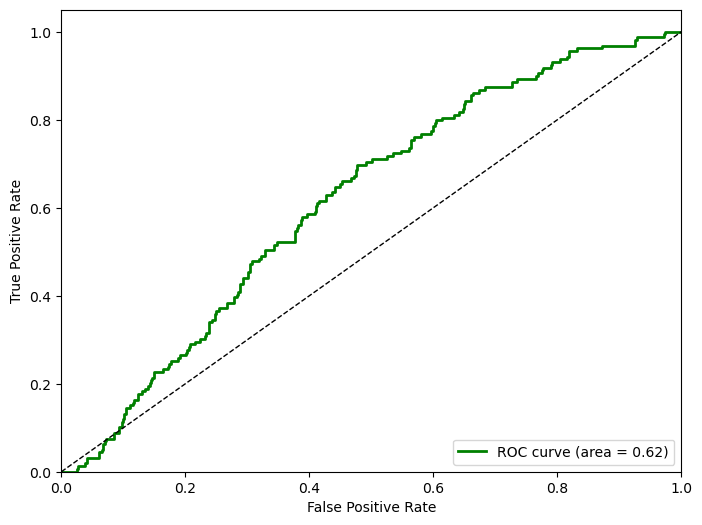

In [11]:
#RF  with optuna and smote
def objective(trial):

    # parameter grid
    n_estimators = trial.suggest_int('n_estimators', 100, 600, step=50)
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30, 50, 60])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5, 7, 10, 12, 14, 16])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2, 4, 6, 8, 10, 12, 14, 16, 18])
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    # Setup the classifier
    classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        random_state=42
    )

    # Create a pipeline
    pipeline = IMBPipeline([
        ('smote', smote),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=3)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

#pruner = MedianPruner()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
classifier = RandomForestClassifier(**best_params, random_state=random_state)
best_pipeline = IMBPipeline([
    ('smote', smote),
    ('classifier', classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

In [44]:
#svm with gridsearchcv
classifier = svm.SVC()

# create pipeline
pipeline = IMBPipeline(steps=[ 
    ('smote', smote),
    ('classifier', classifier)
])


param_grid = [
    {'classifier__kernel' : ['linear'], 'classifier__C' : [0.1, 1, 10]},
    {'classifier__kernel' : ['rbf'], 'classifier__C' : [0.1, 1, 10], 'classifier__gamma' : ['scale', 'auto', 0.1, 1]},
    {'classifier__kernel' : ['poly'], 'classifier__C' : [0.1, 1, 10], 'classifier__degree' : [2, 3, 4], 'classifier__gamma' : ['scale', 'auto', 0.1, 1], 'classifier__coef0' : [0, 0.5, 1]},
    {'classifier__kernel' : ['sigmoid'], 'classifier__C' : [0.1, 1, 10], 'classifier__gamma' : ['scale', 'auto', 0.1, 1], 'classifier__coef0' : [0, 0.5, 1]}
]


skf = StratifiedKFold(n_splits=5)

# Grid search with pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring='f1', verbose = 1)
grid_search.fit(X_train, y_train)


# eval metrics
print(grid_search.best_params_)

# Make predictions on the test set
predictions = grid_search.predict(X_test)
probabilities = grid_search.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

Fitting 5 folds for each of 159 candidates, totalling 795 fits


[I 2024-05-12 01:45:12,703] A new study created in memory with name: no-name-4cf79945-3ab4-483b-b071-fff50eb067d1
[I 2024-05-12 01:45:28,070] Trial 0 finished with value: 0.29493526475280935 and parameters: {'kernel': 'linear', 'C': 4.474579181580904e-05, 'gamma': 'auto'}. Best is trial 0 with value: 0.29493526475280935.
[I 2024-05-12 01:45:45,394] Trial 1 finished with value: 0.2613076377047366 and parameters: {'kernel': 'sigmoid', 'C': 0.00954719833939128, 'gamma': 'auto', 'coef0': 0.5540952425636366}. Best is trial 0 with value: 0.29493526475280935.
[I 2024-05-12 01:46:02,355] Trial 2 finished with value: 0.20096997571674868 and parameters: {'kernel': 'rbf', 'C': 96.4838715614725, 'gamma': 'auto'}. Best is trial 0 with value: 0.29493526475280935.
[I 2024-05-12 01:46:17,865] Trial 3 finished with value: 0.294695287820471 and parameters: {'kernel': 'poly', 'C': 3.927364654782511e-06, 'gamma': 'auto', 'coef0': 0.9054918204747303}. Best is trial 0 with value: 0.29493526475280935.
[I 202

Best trial:
 Value: 0.29763439441091294
 Params: 
    kernel: linear
    C: 2.215810023319728e-05
    gamma: auto
Accuracy: 0.6082375478927203
Binary F1: 0.30085470085470084
Weighted F1 0.6628424847916898
Recall 0.5534591194968553


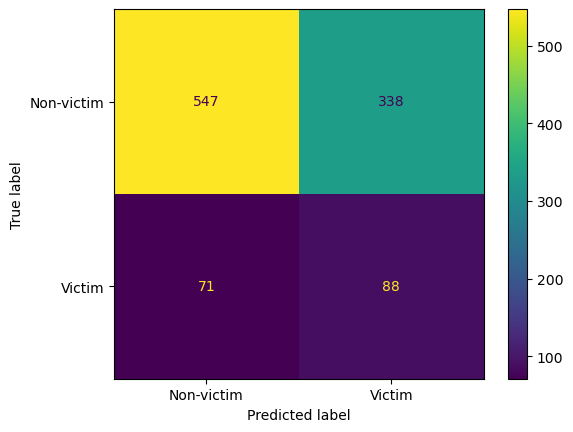

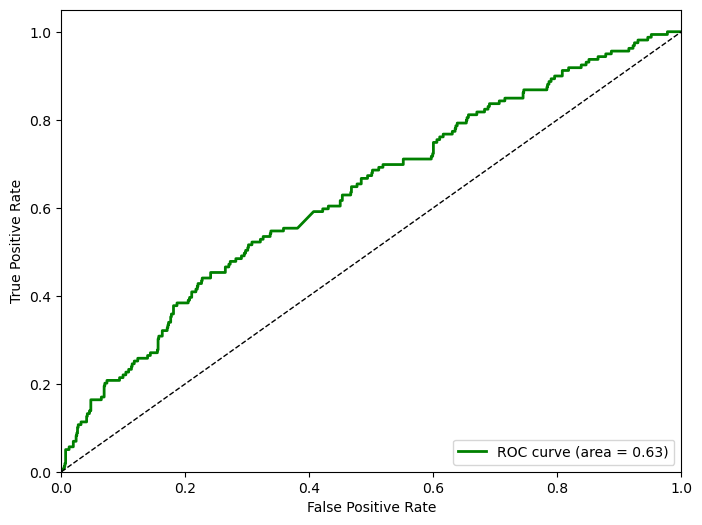

In [12]:
#optuna optimalisation voor svm
import optuna
from optuna.pruners import MedianPruner

def objective(trial):
    # Suggest values for the hyperparameters
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid', 'poly'])
    C = trial.suggest_float('C', 1e-6, 1e2, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    # Additional parameters for 'poly' and 'sigmoid'
    coef0 = trial.suggest_float('coef0', 0, 1) if kernel in ['sigmoid', 'poly'] else 0.0

    # Create the SVM classifier
    classifier = svm.SVC(kernel=kernel, C=C, gamma=gamma, coef0=coef0, random_state=random_state)

    # Create a pipeline
    pipeline = IMBPipeline([
        ('smote', smote),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=3)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

#pruner = MedianPruner()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
classifier = svm.SVC(**best_params, probability=True, random_state=random_state)
best_pipeline = IMBPipeline([
    ('smote', smote),
    ('classifier', classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

param_grid = {
    'classifier__C': [1],
    'classifier__kernel': ['linear', 'poly', 'rbf', "sigmoid"],
    'classifier__gamma' : ['scale', 'auto', 0.1, 1],
    'classifier__degree' : [2, 3, 4],
    'classifier__coef0' : [0, 0.5, 1]
}
{'classifier__C': 1, 'classifier__coef0': 0, 'classifier__degree': 2, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}

Accuracy: 0.5354406130268199
Binary F1: 0.310099573257468
Weighted F1 0.5980805410493474
Recall 0.6855345911949685


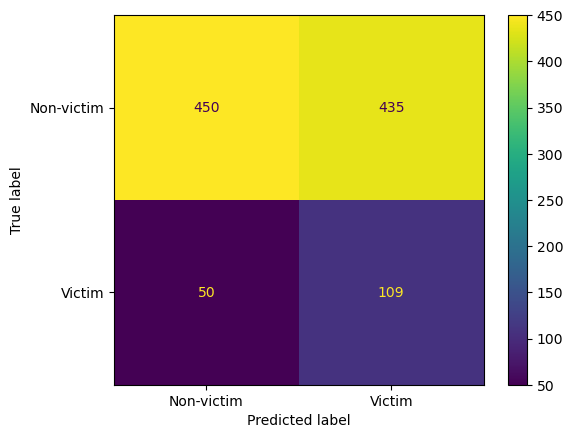

In [17]:
#SVM
classifier = svm.SVC(C = 1, coef0= 0, degree=2, gamma='scale', kernel='poly')

# create pipeline
pipeline = IMBPipeline(steps=[
    ('smote', smote),
    ('classifier', classifier)
])

pipeline.fit(X_smote, y_smote)

# Make predictions on the test set
predictions = pipeline.predict(X_test)
probabilities = pipeline.predict_proba(X_test)[:, 1]

y_pred = np.round(predictions)

# eval metrics
evalution(y_test, y_pred, probabilities)

In [20]:
#Knn gridsearch optimisation
classifier = KNeighborsClassifier()

# create pipeline
pipeline = IMBPipeline(steps=[ 
    ('smote', smote),
    ('classifier', classifier)
])

param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 10],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'classifier__leaf_size' : [40, 50, 60],
    'classifier__p' : [1,2]
}

skf = StratifiedKFold(n_splits=5)

# Grid search with pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring='f1', verbose = 1, n_jobs=-1)
grid_search.fit(X_train, y_train)


# eval metrics
print(grid_search.best_params_)

# Make predictions on the test set
predictions = grid_search.predict(X_test)
probabilities = grid_search.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
{'classifier__algorithm': 'ball_tree', 'classifier__leaf_size': 50, 'classifier__n_neighbors': 5, 'classifier__p': 1, 'classifier__weights': 'distance'}
Accuracy: 0.4784276126558006
Binary F1: 0.2568306010928962
Weighted F1 0.5465105940517889
Recall 0.5949367088607594


[I 2024-05-10 15:47:09,916] A new study created in memory with name: no-name-534404f8-e0c6-479d-8414-6cf1015b4fc5
[I 2024-05-10 15:47:23,377] Trial 0 finished with value: 0.2705564793474249 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 50, 'p': 2}. Best is trial 0 with value: 0.2705564793474249.
[I 2024-05-10 15:47:38,906] Trial 1 finished with value: 0.26110163294082617 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 45, 'p': 1}. Best is trial 0 with value: 0.2705564793474249.
[I 2024-05-10 15:47:53,576] Trial 2 finished with value: 0.25786287124627943 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 45, 'p': 2}. Best is trial 0 with value: 0.2705564793474249.
[I 2024-05-10 15:48:09,058] Trial 3 finished with value: 0.2557977518729232 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 45, 'p': 1}. Best i

Best trial:
 Value: 0.2705564793474249
 Params: 
    n_neighbors: 9
    weights: uniform
    algorithm: kd_tree
    leaf_size: 50
    p: 2
Accuracy: 0.4875478927203065
Binary F1: 0.27994616419919244
Weighted F1 0.5531469519184281
Recall 0.6540880503144654


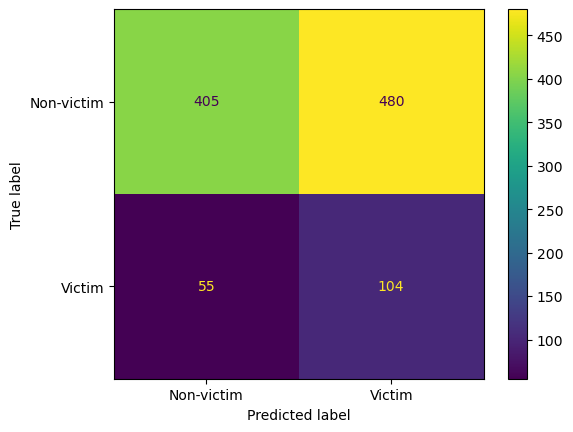

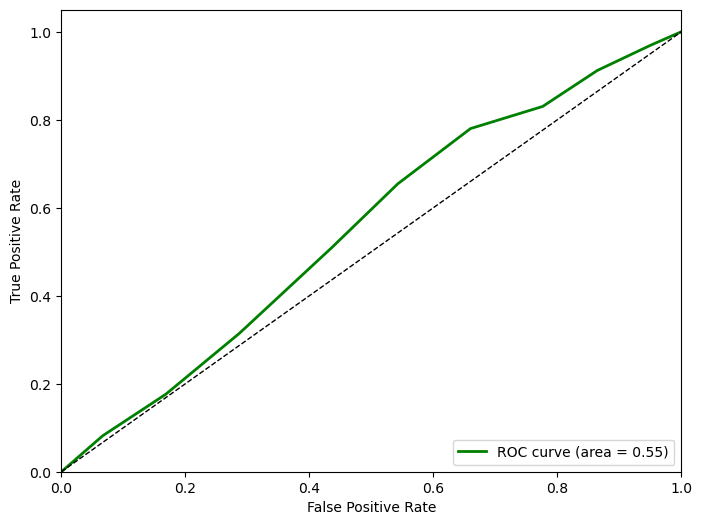

In [10]:
#optuna for knn with smote
def objective(trial):

    # parameter grid
    n_neighbors = trial.suggest_int('n_neighbors', 2, 10)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    leaf_size = trial.suggest_int('leaf_size', 20, 60, step=5)
    p = trial.suggest_categorical('p', [1, 2])

    # Set up the classifier
    classifier = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        leaf_size=leaf_size,
        p=p
    )

    # Create a pipeline
    pipeline = IMBPipeline([
        ('smote', smote),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=3)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

#pruner = MedianPruner()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
classifier = KNeighborsClassifier(**best_params)
best_pipeline = IMBPipeline([
    ('smote', smote),
    ('classifier', classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

Accuracy: 0.4875478927203065
Binary F1: 0.27994616419919244
Weighted F1 0.5531469519184281
Recall 0.6540880503144654


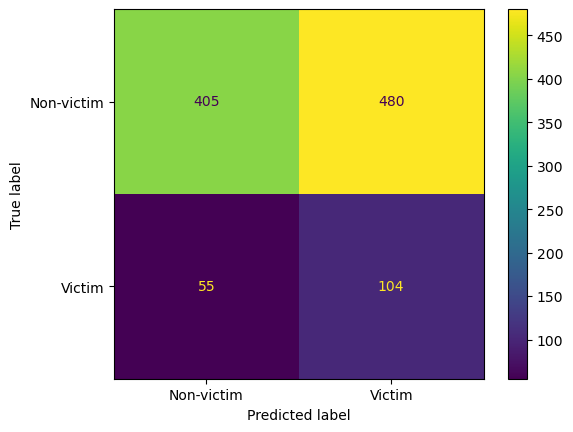

In [18]:
#knn
classifier = KNeighborsClassifier(algorithm= 'ball_tree', leaf_size=50, n_neighbors=5, p=1, weights='distance')

# create pipeline
pipeline = IMBPipeline(steps=[
    ('smote', smote),
    ('classifier', classifier)
])

pipeline.fit(X_smote, y_smote)

# Make predictions on the test set
predictions = pipeline.predict(X_test)
probabilities = pipeline.predict_proba(X_test)[:, 1]

y_pred = np.round(predictions)

# eval metrics
evalution(y_test, y_pred, probabilities)

# Exclusion of RA parameters

In [2]:
#load data again
df = pd.read_csv('binary_task.csv')

parameters = df.drop('all', axis=1)
y = df['all']

parameters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 48 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   geslacht  5216 non-null   int64  
 1   leeftijd  5216 non-null   float64
 2   aantalki  5216 non-null   int64  
 3   oplcat    5216 non-null   int64  
 4   ac18f092  5216 non-null   int64  
 5   ac18f007  5216 non-null   int64  
 6   ac18f036  5216 non-null   float64
 7   ac18f045  5216 non-null   float64
 8   ac18f047  5216 non-null   float64
 9   ac18f048  5216 non-null   float64
 10  ac18f049  5216 non-null   float64
 11  ac18f051  5216 non-null   float64
 12  ac18f052  5216 non-null   float64
 13  ac18f053  5216 non-null   float64
 14  ac18f054  5216 non-null   float64
 15  ac18f066  5216 non-null   float64
 16  ac18f067  5216 non-null   float64
 17  ac18f069  5216 non-null   float64
 18  ac18f070  5216 non-null   float64
 19  ac18f071  5216 non-null   float64
 20  ac18f080  5216 non-null   floa

In [9]:
#removal of RA parameters
exclude = ['ac18f036', 'ac18f045', 'ac18f047', 'ac18f048', 'ac18f049', 'ac18f051', 'ac18f052', 'ac18f053', 'ac18f054', 'cs17j251', 'cs17j252', 'cs17j253', 'cs17j254', 'cs17j429', 'cs17j430', 'cs17j260', 'cs17j261', 'cs17j262', 'cs17j263', 'cs17j431', 'cs17j432', 'cs17j486', 'cs17j264', 'cs17j435', 'cs17j265', 'cs17j266']

RA_parameters = parameters.drop(exclude, axis=1)
RA_parameters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   geslacht  5216 non-null   int64  
 1   leeftijd  5216 non-null   float64
 2   aantalki  5216 non-null   int64  
 3   oplcat    5216 non-null   int64  
 4   ac18f092  5216 non-null   int64  
 5   ac18f007  5216 non-null   int64  
 6   ac18f066  5216 non-null   float64
 7   ac18f067  5216 non-null   float64
 8   ac18f069  5216 non-null   float64
 9   ac18f070  5216 non-null   float64
 10  ac18f071  5216 non-null   float64
 11  ac18f080  5216 non-null   float64
 12  ac18f081  5216 non-null   float64
 13  ac18f082  5216 non-null   float64
 14  ac18f083  5216 non-null   float64
 15  ac18f084  5216 non-null   float64
 16  ac18f085  5216 non-null   float64
 17  ac18f087  5216 non-null   float64
 18  ac18f088  5216 non-null   float64
 19  ac18f089  5216 non-null   float64
 20  ac18f090  5216 non-null   floa

In [10]:
#preprocess certain parameters
onehot_cols = ['ac18f092', 'ac18f007', 'ac18f066', 'ac18f067', 'ac18f069', 'ac18f070', 'ac18f071', 'ac18f080', 'ac18f081', 'ac18f082', 'ac18f083', 'ac18f084', 'ac18f085', 'ac18f087', 'ac18f088', 'ac18f089', 'ac18f090', 'ac18f091']

onehot = ce.OneHotEncoder(cols= onehot_cols)

RA_parameters_onehot = onehot.fit_transform(RA_parameters)
RA_parameters_onehot.head()

geslacht  leeftijd  aantalki  oplcat  ac18f092_1  ac18f092_2  ac18f092_3  \
0         0      62.0         0       5           1           0           0   
1         0      55.0         2       6           1           0           0   
2         1      42.0         2       3           0           1           0   
3         1      71.0         0       2           1           0           0   
4         0      43.0         3       6           0           0           1   

   ac18f092_4  ac18f092_5  ac18f092_6  ...  ac18f088_3  ac18f089_1  \
0           0           0           0  ...           0           1   
1           0           0           0  ...           0           1   
2           0           0           0  ...           0           1   
3           0           0           0  ...           0           1   
4           0           0           0  ...           0           1   

   ac18f089_2  ac18f089_3  ac18f090_1  ac18f090_2  ac18f090_3  ac18f091_1  \
0           0           0           1           0           0           1   
1           0           0           1           0           0           1   
2           0           0           1           0           0           1   
3           0           0           1           0           0           1   
4           0           0           1           0           0           1   

   ac18f091_2  ac18f091_3  
0           0           0  
1           0           0  
2           0           0  
3           0           0  
4           0           0  

[5 rows x 74 columns]

In [11]:
X_train_RA, X_test_RA, y_train_RA, y_test_RA = train_test_split(RA_parameters_onehot, y, test_size=0.2, stratify= y, random_state=random_state)
X_train_RA.head()

geslacht  leeftijd  aantalki  oplcat  ac18f092_1  ac18f092_2  \
4191         0      65.0         0       4           1           0   
509          1      54.0         2       5           0           1   
1344         0      17.0         2       1           0           0   
1825         1      44.0         3       5           0           1   
1071         1      71.0         0       2           1           0   

      ac18f092_3  ac18f092_4  ac18f092_5  ac18f092_6  ...  ac18f088_3  \
4191           0           0           0           0  ...           0   
509            0           0           0           0  ...           0   
1344           0           1           0           0  ...           0   
1825           0           0           0           0  ...           0   
1071           0           0           0           0  ...           0   

      ac18f089_1  ac18f089_2  ac18f089_3  ac18f090_1  ac18f090_2  ac18f090_3  \
4191           1           0           0           1           0           0   
509            1           0           0           1           0           0   
1344           1           0           0           1           0           0   
1825           1           0           0           1           0           0   
1071           1           0           0           1           0           0   

      ac18f091_1  ac18f091_2  ac18f091_3  
4191           1           0           0  
509            1           0           0  
1344           1           0           0  
1825           1           0           0  
1071           1           0           0  

[5 rows x 74 columns]

[I 2024-05-12 22:12:17,289] A new study created in memory with name: no-name-6b132309-6e2f-4e01-92f3-68122ced16bd
[I 2024-05-12 22:12:18,102] Trial 0 finished with value: 0.28850970700765405 and parameters: {'solver': 'lbfgs', 'C': 0.06425913857970016, 'max_iter': 600, 'warm_start': True}. Best is trial 0 with value: 0.28850970700765405.
[I 2024-05-12 22:12:18,367] Trial 1 finished with value: 0.28777313270004634 and parameters: {'solver': 'newton-cg', 'C': 0.04092374033036248, 'max_iter': 200, 'warm_start': True}. Best is trial 0 with value: 0.28850970700765405.
[I 2024-05-12 22:12:18,629] Trial 2 finished with value: 0.2871561296260945 and parameters: {'solver': 'newton-cg', 'C': 0.04554919868877938, 'max_iter': 100, 'warm_start': False}. Best is trial 0 with value: 0.28850970700765405.
[I 2024-05-12 22:12:18,868] Trial 3 finished with value: 0.2939036066574278 and parameters: {'solver': 'newton-cg', 'C': 6.01578495479559e-06, 'max_iter': 700, 'warm_start': False}. Best is trial 3 wi

Best trial:
 Value: 0.2949021537946413
 Params: 
    solver: newton-cg
    C: 0.00022200333440002383
    max_iter: 600
    warm_start: True
Accuracy: 0.6101532567049809
Binary F1: 0.3089983022071307
Weighted F1 0.6645982151232046
Recall 0.5723270440251572


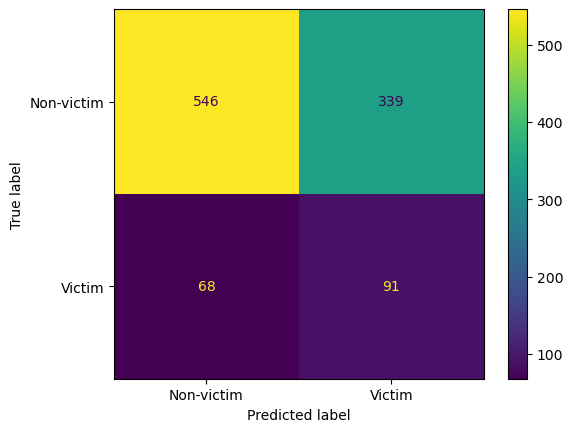

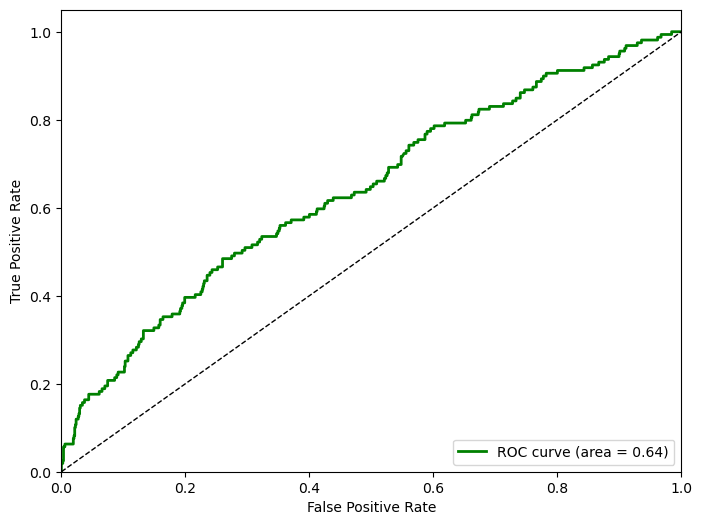

In [13]:
def objective(trial):
    # Suggest values for the hyperparameters
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg'])
    C = trial.suggest_float('C', 1e-6, 1e-1, log = True)
    max_iter = trial.suggest_categorical('max_iter', [100, 200, 300, 500, 600, 700])
    warm_start = trial.suggest_categorical('warm_start', [True, False])

    # Create the classifier with suggested parameters
    classifier = LogisticRegression(solver=solver, C=C, max_iter=max_iter, warm_start=warm_start, random_state=random_state)
    
    # Create a pipeline
    pipeline = IMBPipeline([
        ('smote', ros),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=3)
    scores = []

    for train_idx, valid_idx in skf.split(X_train_RA, y_train_RA):
        X_train_fold, X_valid_fold = X_train_RA.iloc[train_idx], X_train_RA.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train_RA.iloc[train_idx], y_train_RA.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
best_classifier = LogisticRegression(**best_params, random_state=random_state)
best_pipeline = IMBPipeline([
    ('smote', ros),
    ('classifier', best_classifier)
])

best_pipeline.fit(X_train_RA, y_train_RA)

predictions = best_pipeline.predict(X_test_RA)
probabilities = best_pipeline.predict_proba(X_test_RA)[:, 1]

y_pred = predictions
evalution(y_test_RA, y_pred, probabilities)

# exclusion of SC parameters
As the data has already been loaded again, it does not need to happen again.

In [40]:
parameters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 48 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   geslacht  5216 non-null   int64  
 1   leeftijd  5216 non-null   float64
 2   aantalki  5216 non-null   int64  
 3   oplcat    5216 non-null   int64  
 4   ac18f092  5216 non-null   int64  
 5   ac18f007  5216 non-null   int64  
 6   ac18f036  5216 non-null   float64
 7   ac18f045  5216 non-null   float64
 8   ac18f047  5216 non-null   float64
 9   ac18f048  5216 non-null   float64
 10  ac18f049  5216 non-null   float64
 11  ac18f051  5216 non-null   float64
 12  ac18f052  5216 non-null   float64
 13  ac18f053  5216 non-null   float64
 14  ac18f054  5216 non-null   float64
 15  ac18f066  5216 non-null   float64
 16  ac18f067  5216 non-null   float64
 17  ac18f069  5216 non-null   float64
 18  ac18f070  5216 non-null   float64
 19  ac18f071  5216 non-null   float64
 20  ac18f080  5216 non-null   floa

In [14]:
#Removal of SC
exclude = ['ac18f080', 'ac18f081', 'ac18f082', 'ac18f083', 'ac18f084', 'ac18f085', 'ac18f087', 'ac18f088', 'ac18f089', 'ac18f090', 'ac18f091']
SC_parameters = parameters.drop(exclude, axis=1)
SC_parameters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 37 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   geslacht  5216 non-null   int64  
 1   leeftijd  5216 non-null   float64
 2   aantalki  5216 non-null   int64  
 3   oplcat    5216 non-null   int64  
 4   ac18f092  5216 non-null   int64  
 5   ac18f007  5216 non-null   int64  
 6   ac18f036  5216 non-null   float64
 7   ac18f045  5216 non-null   float64
 8   ac18f047  5216 non-null   float64
 9   ac18f048  5216 non-null   float64
 10  ac18f049  5216 non-null   float64
 11  ac18f051  5216 non-null   float64
 12  ac18f052  5216 non-null   float64
 13  ac18f053  5216 non-null   float64
 14  ac18f054  5216 non-null   float64
 15  ac18f066  5216 non-null   float64
 16  ac18f067  5216 non-null   float64
 17  ac18f069  5216 non-null   float64
 18  ac18f070  5216 non-null   float64
 19  ac18f071  5216 non-null   float64
 20  cs17j251  5216 non-null   int6

In [15]:
#preprocess/onehot certain columns
onehot_cols = ['ac18f092', 'ac18f007', 'ac18f045', 'ac18f066', 'ac18f067', 'ac18f069', 'ac18f070', 'ac18f071']

onehot = ce.OneHotEncoder(cols= onehot_cols)

SC_parameters = onehot.fit_transform(SC_parameters)
SC_parameters.head()

geslacht  leeftijd  aantalki  oplcat  ac18f092_1  ac18f092_2  ac18f092_3  \
0         0      62.0         0       5           1           0           0   
1         0      55.0         2       6           1           0           0   
2         1      42.0         2       3           0           1           0   
3         1      71.0         0       2           1           0           0   
4         0      43.0         3       6           0           0           1   

   ac18f092_4  ac18f092_5  ac18f092_6  ...  cs17j261  cs17j262  cs17j263  \
0           0           0           0  ...         0         1         1   
1           0           0           0  ...         0         1         0   
2           0           0           0  ...         0         1         0   
3           0           0           0  ...         1         1         1   
4           0           0           0  ...         1         1         1   

   cs17j431  cs17j432  cs17j486  cs17j264  cs17j435  cs17j265  cs17j266  
0         1         1         1         1         0         1         1  
1         1         1         0         0         0         0         0  
2         1         0         1         1         0         0         1  
3         1         0         1         0         0         0         0  
4         1         1         1         1         0         1         1  

[5 rows x 71 columns]

In [16]:
X_train_SC, X_test_SC, y_train_SC, y_test_SC = train_test_split(SC_parameters, y, test_size=0.2, stratify= y, random_state=random_state)
X_train_SC.head()

geslacht  leeftijd  aantalki  oplcat  ac18f092_1  ac18f092_2  \
4191         0      65.0         0       4           1           0   
509          1      54.0         2       5           0           1   
1344         0      17.0         2       1           0           0   
1825         1      44.0         3       5           0           1   
1071         1      71.0         0       2           1           0   

      ac18f092_3  ac18f092_4  ac18f092_5  ac18f092_6  ...  cs17j261  cs17j262  \
4191           0           0           0           0  ...         1         0   
509            0           0           0           0  ...         0         1   
1344           0           1           0           0  ...         0         0   
1825           0           0           0           0  ...         0         0   
1071           0           0           0           0  ...         0         0   

      cs17j263  cs17j431  cs17j432  cs17j486  cs17j264  cs17j435  cs17j265  \
4191         0         1         1         1         1         0         0   
509          0         0         0         0         1         0         1   
1344         1         1         0         0         1         0         0   
1825         0         1         0         0         1         0         0   
1071         0         0         0         0         1         0         0   

      cs17j266  
4191         1  
509          1  
1344         1  
1825         0  
1071         0  

[5 rows x 71 columns]

[I 2024-05-12 22:12:47,185] A new study created in memory with name: no-name-bbbd84d5-b6c0-4dd0-8c67-ab8423ae4f9e
[I 2024-05-12 22:12:47,464] Trial 0 finished with value: 0.3155339774184029 and parameters: {'solver': 'newton-cg', 'C': 0.00142014463367545, 'max_iter': 600, 'warm_start': True}. Best is trial 0 with value: 0.3155339774184029.
[I 2024-05-12 22:12:47,783] Trial 1 finished with value: 0.31929326687415416 and parameters: {'solver': 'newton-cg', 'C': 0.009690679051506394, 'max_iter': 100, 'warm_start': False}. Best is trial 1 with value: 0.31929326687415416.
[I 2024-05-12 22:12:48,029] Trial 2 finished with value: 0.3154022254984847 and parameters: {'solver': 'newton-cg', 'C': 0.0013947938049627057, 'max_iter': 700, 'warm_start': True}. Best is trial 1 with value: 0.31929326687415416.
[I 2024-05-12 22:12:48,296] Trial 3 finished with value: 0.3192433033549927 and parameters: {'solver': 'newton-cg', 'C': 0.08636494215838451, 'max_iter': 500, 'warm_start': False}. Best is trial 

Best trial:
 Value: 0.32264416496841175
 Params: 
    solver: newton-cg
    C: 0.04983808472129799
    max_iter: 100
    warm_start: False
Accuracy: 0.6522988505747126
Binary F1: 0.36203866432337434
Weighted F1 0.7002615278288838
Recall 0.6477987421383647


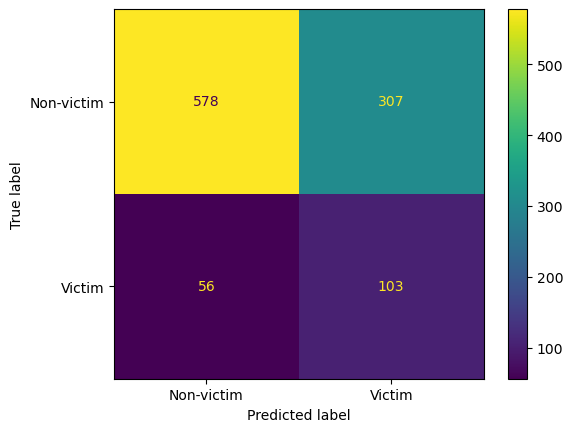

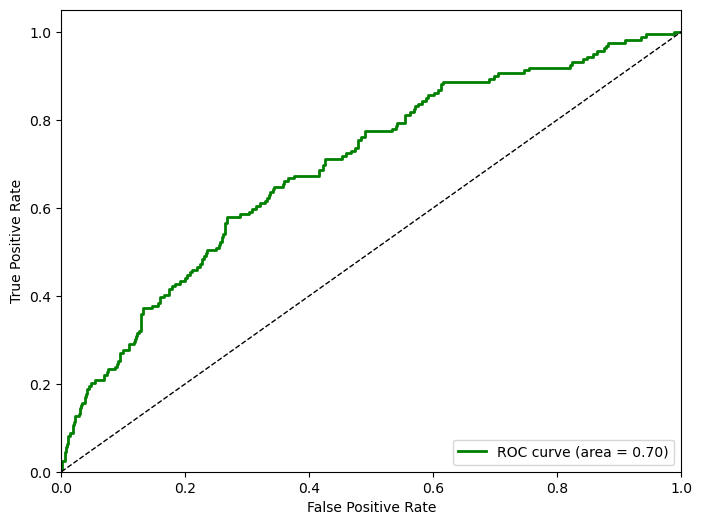

In [17]:
def objective(trial):
    # Suggest values for the hyperparameters
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg'])
    C = trial.suggest_float('C', 1e-6, 1e-1, log = True)
    max_iter = trial.suggest_categorical('max_iter', [100, 200, 300, 500, 600, 700])
    warm_start = trial.suggest_categorical('warm_start', [True, False])

    # Create the classifier with suggested parameters
    classifier = LogisticRegression(solver=solver, C=C, max_iter=max_iter, warm_start=warm_start, random_state=random_state)
    
    # Create a pipeline
    pipeline = IMBPipeline([
        ('smote', ros),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=3)
    scores = []

    for train_idx, valid_idx in skf.split(X_train_SC, y_train_SC):
        X_train_fold, X_valid_fold = X_train_SC.iloc[train_idx], X_train_SC.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train_SC.iloc[train_idx], y_train_SC.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
best_classifier = LogisticRegression(**best_params, random_state=random_state)
best_pipeline = IMBPipeline([
    ('smote', ros),
    ('classifier', best_classifier)
])

best_pipeline.fit(X_train_SC, y_train_SC)

predictions = best_pipeline.predict(X_test_SC)
probabilities = best_pipeline.predict_proba(X_test_SC)[:, 1]

y_pred = predictions
evalution(y_test_SC, y_pred, probabilities)

# Removal of both RA and SC as a base model

In [3]:
#removal of RA and SC
exclude = ['ac18f036', 'ac18f045', 'ac18f047', 'ac18f048', 'ac18f049', 'ac18f051', 'ac18f052', 'ac18f053', 'ac18f054', 'cs17j251', 'cs17j252', 'cs17j253', 'cs17j254', 'cs17j429', 'cs17j430', 'cs17j260', 'cs17j261', 'cs17j262', 'cs17j263', 'cs17j431', 'cs17j432', 'cs17j486', 'cs17j264', 'cs17j435', 'cs17j265', 'cs17j266', 'ac18f080', 'ac18f081', 'ac18f082', 'ac18f083', 'ac18f084', 'ac18f085', 'ac18f087', 'ac18f088', 'ac18f089', 'ac18f090', 'ac18f091']
baseline = parameters.drop(exclude, axis=1)
baseline.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   geslacht  5216 non-null   int64  
 1   leeftijd  5216 non-null   float64
 2   aantalki  5216 non-null   int64  
 3   oplcat    5216 non-null   int64  
 4   ac18f092  5216 non-null   int64  
 5   ac18f007  5216 non-null   int64  
 6   ac18f066  5216 non-null   float64
 7   ac18f067  5216 non-null   float64
 8   ac18f069  5216 non-null   float64
 9   ac18f070  5216 non-null   float64
 10  ac18f071  5216 non-null   float64
dtypes: float64(6), int64(5)
memory usage: 448.4 KB


In [4]:
#preprocess/onehot certain columns
onehot_cols = ['ac18f092', 'ac18f007', 'ac18f066', 'ac18f067', 'ac18f069', 'ac18f070', 'ac18f071']

onehot = ce.OneHotEncoder(cols= onehot_cols)

baseline = onehot.fit_transform(baseline)
baseline.head()

geslacht  leeftijd  aantalki  oplcat  ac18f092_1  ac18f092_2  ac18f092_3  \
0         0      62.0         0       5           1           0           0   
1         0      55.0         2       6           1           0           0   
2         1      42.0         2       3           0           1           0   
3         1      71.0         0       2           1           0           0   
4         0      43.0         3       6           0           0           1   

   ac18f092_4  ac18f092_5  ac18f092_6  ...  ac18f069_3  ac18f069_4  \
0           0           0           0  ...           0           0   
1           0           0           0  ...           0           0   
2           0           0           0  ...           0           0   
3           0           0           0  ...           0           0   
4           0           0           0  ...           0           0   

   ac18f070_1  ac18f070_2  ac18f070_3  ac18f070_4  ac18f071_1  ac18f071_2  \
0           1           0           0           0           1           0   
1           0           1           0           0           0           1   
2           1           0           0           0           1           0   
3           1           0           0           0           0           1   
4           1           0           0           0           1           0   

   ac18f071_3  ac18f071_4  
0           0           0  
1           0           0  
2           0           0  
3           0           0  
4           0           0  

[5 rows x 41 columns]

In [5]:
#initialise ros
ros = RandomOverSampler(random_state=random_state)

In [9]:
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(baseline, y, test_size=0.2, stratify= y, random_state=random_state)
X_train_base.head()

geslacht  leeftijd  aantalki  oplcat  ac18f092_1  ac18f092_2  \
4191         0      65.0         0       4           1           0   
509          1      54.0         2       5           0           1   
1344         0      17.0         2       1           0           0   
1825         1      44.0         3       5           0           1   
1071         1      71.0         0       2           1           0   

      ac18f092_3  ac18f092_4  ac18f092_5  ac18f092_6  ...  ac18f069_3  \
4191           0           0           0           0  ...           0   
509            0           0           0           0  ...           1   
1344           0           1           0           0  ...           1   
1825           0           0           0           0  ...           1   
1071           0           0           0           0  ...           1   

      ac18f069_4  ac18f070_1  ac18f070_2  ac18f070_3  ac18f070_4  ac18f071_1  \
4191           0           1           0           0           0           1   
509            0           1           0           0           0           0   
1344           0           0           0           1           0           1   
1825           0           0           0           1           0           0   
1071           0           0           0           1           0           0   

      ac18f071_2  ac18f071_3  ac18f071_4  
4191           0           0           0  
509            0           1           0  
1344           0           0           0  
1825           0           1           0  
1071           0           1           0  

[5 rows x 41 columns]

[I 2024-05-13 16:28:22,072] A new study created in memory with name: no-name-e7e793f7-0fba-40e4-afe6-f4f3b67a78d8
[I 2024-05-13 16:28:22,322] Trial 0 finished with value: 0.28862652766178093 and parameters: {'solver': 'lbfgs', 'C': 0.006301118094810766, 'max_iter': 300, 'warm_start': True}. Best is trial 0 with value: 0.28862652766178093.
[I 2024-05-13 16:28:22,509] Trial 1 finished with value: 0.290536632080596 and parameters: {'solver': 'lbfgs', 'C': 0.00020017336310813706, 'max_iter': 700, 'warm_start': False}. Best is trial 1 with value: 0.290536632080596.
[I 2024-05-13 16:28:22,640] Trial 2 finished with value: 0.2940238230469289 and parameters: {'solver': 'lbfgs', 'C': 7.516070376871667e-06, 'max_iter': 500, 'warm_start': False}. Best is trial 2 with value: 0.2940238230469289.
[I 2024-05-13 16:28:22,837] Trial 3 finished with value: 0.2787211509881245 and parameters: {'solver': 'newton-cg', 'C': 0.09069365204488133, 'max_iter': 500, 'warm_start': False}. Best is trial 2 with valu

Best trial:
 Value: 0.2940238230469289
 Params: 
    solver: lbfgs
    C: 7.516070376871667e-06
    max_iter: 500
    warm_start: False
Accuracy: 0.5986590038314177
Binary F1: 0.3074380165289256
Weighted F1 0.6550180216033766
Recall 0.5849056603773585


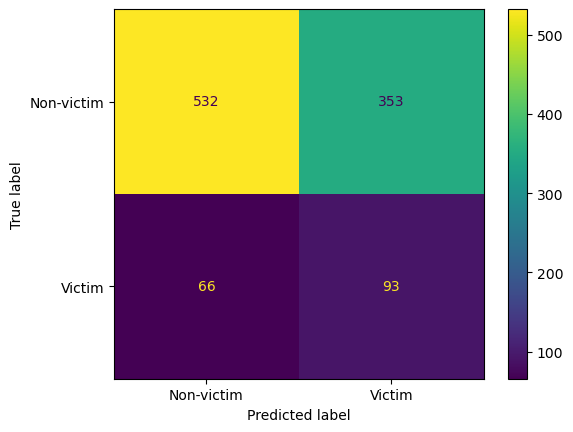

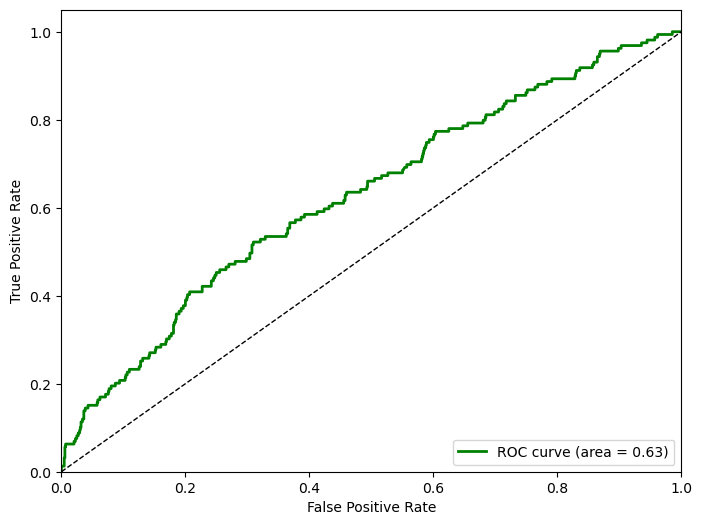

In [12]:
#optuna with LR
def objective(trial):
    # Suggest values for the hyperparameters
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg'])
    C = trial.suggest_float('C', 1e-6, 1e-1, log = True)
    max_iter = trial.suggest_categorical('max_iter', [100, 200, 300, 500, 600, 700])
    warm_start = trial.suggest_categorical('warm_start', [True, False])

    # Create the classifier with suggested parameters
    classifier = LogisticRegression(solver=solver, C=C, max_iter=max_iter, warm_start=warm_start, random_state=random_state)
    
    # Create a pipeline
    pipeline = IMBPipeline([
        ('smote', ros),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=3)
    scores = []

    for train_idx, valid_idx in skf.split(X_train_base, y_train_base):
        X_train_fold, X_valid_fold = X_train_base.iloc[train_idx], X_train_base.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train_base.iloc[train_idx], y_train_base.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
best_classifier = LogisticRegression(**best_params, random_state=random_state)
best_pipeline = IMBPipeline([
    ('smote', ros),
    ('classifier', best_classifier)
])

best_pipeline.fit(X_train_base, y_train_base)

predictions = best_pipeline.predict(X_test_base)
probabilities = best_pipeline.predict_proba(X_test_base)[:, 1]

y_pred = predictions
evalution(y_test_base, y_pred, probabilities)